In [2]:
import os
import sys
import time
import random
import warnings
import collections
from dateutil.relativedelta import relativedelta
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from sklearn.experimental import enable_hist_gradient_boosting, enable_halving_search_cv  
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, HalvingRandomSearchCV 
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor, StackingRegressor, HistGradientBoostingRegressor , HistGradientBoostingClassifier


# Import required modules
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# from sklearn.linear_model import Ridge, Lasso, BayesianRidge, ElasticNet
from sklearn.preprocessing import OneHotEncoder

sys.path.append('../../src')
import cb_utils
import cb_model_utils

sns.set(style="darkgrid")
pd.options.display.max_columns = 500

%load_ext autoreload
%autoreload 2

/Users/bp/miniforge3/envs/data-analytics/lib/python3.10/site-packages/sklearn/experimental/enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


### Load raw data

In [3]:
query = f"select * from attribution_prediction_model;"
df = cb_utils.sql_query_to_df(query, use_cache=True, source='msh_member_doc')

Pulling query from db


In [33]:
df.head()

,patient_id,is_attributed_in_prediction_year,patient_age,gender,primary_referring_partner_id,primary_rpo_id,patient_payer_id,contract_type_key,current_primary_rpl_type,current_primary_rpl_is_nursing_home,current_primary_rpl_is_urgent_care,current_primary_rpo_org_type,cms_plan_type,ma_product_key,cca_eligible_appts,provider_appts,total_appts,appt_count_group,distinct_rpls,distinct_rpos,distinct_physicians,appts_with_primary_rpl,appts_with_primary_rpo,nursing_home_appts,distinct_appt_months,max_appt_month,appts_allergy_immunology,appts_anesthesiology,appts_clinical_neuropsychologist,appts_clinical_nurse_specialist,appts_colon_rectal_surgery,appts_dermatology,appts_emergency_medicine,appts_family_medicine,appts_general_practice,appts_hospitalist,appts_internal_medicine,appts_licensed_practical_nurse,appts_neuromusculoskeletal_sports_medicine,appts_nurse_practitioner,appts_obstetrics_gynecology,appts_ophthalmology,appts_otolaryngology,appts_pathology,appts_pediatrics,appts_physical_therapist,appts_physician_assistant,appts_podiatrist,appts_psychiatry_neurology,appts_psychologist,appts_radiology,appts_registered_nurse,appts_surgery,appts_urology
0,674631,False,67.0,Female,1476,1101,38,ma,multi_specialty_provider_group,False,False,Independent Primary Care,Local PPO,individual,0,0,0,no_appts,0,0,0,0,0,0,0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,36956,False,71.0,Male,45,4,2,ma,rhc,False,False,Independent Primary Care,HMO,dsnp,3,3,20,greater_than_6_appts,1,1,4,20,20,0,12,12.0,0,0,0,0,0,0,0,12,0,0,2,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,412267,True,66.0,Female,1012,742,81,om,health_system,False,False,CAH,None,None,1,1,1,one_appt,1,1,1,1,1,0,1,10.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,74149,True,73.0,Female,152,11,147,ma,rhc,False,False,Hospital - RHC,HMOPOS,dsnp,3,3,3,three_to_five_appts,1,1,1,3,3,0,3,10.0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,667437,True,71.0,Female,1464,1090,81,om,rhc,False,False,Hospital - RHC,None,None,0,2,2,two_appts,1,1,1,2,2,0,2,9.0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [34]:
df.shape

(466967, 54)

In [35]:
df.patient_id.nunique()

466967

In [7]:
# Data preprocessing
print("Dataset shape:", df.shape)
print("Target distribution:")
print(df['is_attributed_in_prediction_year'].value_counts())
print(f"Attribution rate: {df['is_attributed_in_prediction_year'].mean():.3f}")

# Check for missing values
print("\nMissing values per column:")
missing_counts = df.isnull().sum()
print(missing_counts[missing_counts > 0])

# Check data types
print("\nData types:")
print(df.dtypes.value_counts())


Dataset shape: (466967, 54)
Target distribution:
True     278296
False    188671
Name: is_attributed_in_prediction_year, dtype: int64
Attribution rate: 0.596

Missing values per column:
cms_plan_type     286601
ma_product_key    256350
max_appt_month    108876
dtype: int64

Data types:
int64      42
object      7
bool        3
float64     2
dtype: int64


In [31]:
# Prepare features and target
# Remove patient_id as it's just an identifier
features = df.drop(['patient_id', 'is_attributed_in_prediction_year', 'primary_referring_partner_id', 'primary_rpo_id'], axis=1)
target = df['is_attributed_in_prediction_year']

print("Features shape:", features.shape)
print("Features columns:")
print(features.columns.tolist())

# Identify categorical and numerical columns
categorical_cols = features.select_dtypes(include=['object', 'bool']).columns.tolist()

# Add all columns ending with '_id' as categorical (even if they're numeric)
id_columns = [col for col in features.columns if col.endswith('_id')]
categorical_cols.extend(id_columns)
# Remove duplicates while preserving order
categorical_cols = list(dict.fromkeys(categorical_cols))

# Numerical columns are all remaining columns
numerical_cols = [col for col in features.columns if col not in categorical_cols]

print(f"\nCategorical columns ({len(categorical_cols)}):")
print(categorical_cols)
print(f"\nNumerical columns ({len(numerical_cols)}):")
print(numerical_cols)
print(f"\nID columns identified as categorical: {id_columns}")


Features shape: (466967, 50)
Features columns:
['patient_age', 'gender', 'patient_payer_id', 'contract_type_key', 'current_primary_rpl_type', 'current_primary_rpl_is_nursing_home', 'current_primary_rpl_is_urgent_care', 'current_primary_rpo_org_type', 'cms_plan_type', 'ma_product_key', 'cca_eligible_appts', 'provider_appts', 'total_appts', 'appt_count_group', 'distinct_rpls', 'distinct_rpos', 'distinct_physicians', 'appts_with_primary_rpl', 'appts_with_primary_rpo', 'nursing_home_appts', 'distinct_appt_months', 'max_appt_month', 'appts_allergy_immunology', 'appts_anesthesiology', 'appts_clinical_neuropsychologist', 'appts_clinical_nurse_specialist', 'appts_colon_rectal_surgery', 'appts_dermatology', 'appts_emergency_medicine', 'appts_family_medicine', 'appts_general_practice', 'appts_hospitalist', 'appts_internal_medicine', 'appts_licensed_practical_nurse', 'appts_neuromusculoskeletal_sports_medicine', 'appts_nurse_practitioner', 'appts_obstetrics_gynecology', 'appts_ophthalmology', 'ap

In [ ]:
# Import preprocessing tools - No need to fill missing values as HistGradientBoostingClassifier handles them
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix

# Keep original features without filling missing values
features_processed = features.copy()

print("Missing values in original data (will be handled by HistGradientBoostingClassifier):", features_processed.isnull().sum().sum())


Missing values after preprocessing: 0


In [ ]:
# One-hot encode all categorical variables including patient_payer_id
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import sklearn

# Check scikit-learn version for OneHotEncoder parameter compatibility
sklearn_version = sklearn.__version__
use_sparse_output = tuple(map(int, sklearn_version.split('.')[:2])) >= (1, 2)
print(f"Scikit-learn version: {sklearn_version}")
print(f"Using {'sparse_output' if use_sparse_output else 'sparse'} parameter")

# Treat patient_payer_id as a regular categorical variable for one-hot encoding
print(f"All categorical columns: {categorical_cols}")

# Check cardinality of categorical variables
print("\nCardinality of categorical variables:")
for col in categorical_cols:
    print(f"{col}: {features_processed[col].nunique()} unique values")

# Apply One-Hot Encoding to all categorical columns
ohe_features = []
ohe_feature_names = []

for col in categorical_cols:
    if features_processed[col].nunique() <= 20:  # Threshold for one-hot encoding
        # One-hot encode
        # Create OneHotEncoder with version-compatible parameters
        if use_sparse_output:
            ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        else:
            ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
        col_encoded = ohe.fit_transform(features_processed[col].values.reshape(-1, 1))
        
        # Create feature names
        categories = ohe.categories_[0]
        col_names = [f"{col}_{cat}" for cat in categories]
        
        ohe_features.append(col_encoded)
        ohe_feature_names.extend(col_names)
        print(f"One-hot encoded {col} into {len(col_names)} features")
    else:
        # For high cardinality columns, use label encoding as fallback
        le = LabelEncoder()
        col_encoded = le.fit_transform(features_processed[col].astype(str)).reshape(-1, 1)
        ohe_features.append(col_encoded)
        ohe_feature_names.append(col)
        print(f"Label encoded {col} (high cardinality: {features_processed[col].nunique()} categories)")

# Combine all categorical features
if ohe_features:
    categorical_encoded = np.hstack(ohe_features)
    all_categorical_feature_names = ohe_feature_names
else:
    categorical_encoded = np.empty((len(features_processed), 0))
    all_categorical_feature_names = []

# Combine with numerical features
numerical_features = features_processed[numerical_cols].values
all_feature_names = numerical_cols + all_categorical_feature_names

# Final feature matrix
features_final = np.hstack([numerical_features, categorical_encoded])

print(f"\nFinal feature matrix shape: {features_final.shape}")
print(f"Number of features: {len(all_feature_names)}")
print(f"Numerical features: {len(numerical_cols)}")
print(f"Categorical features: {len(all_categorical_feature_names)}")

# Convert to DataFrame for easier handling
features_processed_final = pd.DataFrame(features_final, columns=all_feature_names)
print("\nSample of final processed features:")
print(features_processed_final.head())


Scikit-learn version: 1.1.3
Using sparse parameter
ID columns (high cardinality): ['primary_referring_partner_id', 'primary_rpo_id', 'patient_payer_id']
Non-ID categorical columns: ['gender', 'contract_type_key', 'current_primary_rpl_type', 'current_primary_rpl_is_nursing_home', 'current_primary_rpl_is_urgent_care', 'current_primary_rpo_org_type', 'cms_plan_type', 'ma_product_key', 'appt_count_group']

Cardinality of categorical variables:
gender: 3 unique values
contract_type_key: 2 unique values
current_primary_rpl_type: 11 unique values
current_primary_rpl_is_nursing_home: 2 unique values
current_primary_rpl_is_urgent_care: 2 unique values
current_primary_rpo_org_type: 11 unique values
cms_plan_type: 7 unique values
ma_product_key: 5 unique values
appt_count_group: 5 unique values
primary_referring_partner_id: 1132 unique values
primary_rpo_id: 455 unique values
patient_payer_id: 14 unique values
One-hot encoded gender into 3 features
One-hot encoded contract_type_key into 2 feature

In [11]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    features_processed_final, target, 
    test_size=0.2, 
    random_state=42, 
    stratify=target
)

print(f"Train set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Train target distribution: {y_train.value_counts().to_dict()}")
print(f"Test target distribution: {y_test.value_counts().to_dict()}")


Train set shape: (373573, 91)
Test set shape: (93394, 91)
Train target distribution: {True: 222636, False: 150937}
Test target distribution: {True: 55660, False: 37734}


In [ ]:
# Define model to train - Focus only on HistGradientBoostingClassifier
model = HistGradientBoostingClassifier(
    max_depth=6,
    learning_rate=0.1,
    random_state=42
)

# Function to evaluate model performance
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    results = {
        'Model': model_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_pred_proba)
    }
    
    return results, y_pred, y_pred_proba

print("Model to train: HistGradientBoostingClassifier")


Models to train: ['HistGradientBoosting', 'Random Forest', 'Logistic Regression']


In [ ]:
# Train and evaluate model
print("Training HistGradientBoostingClassifier...")
print("=" * 50)

model_name = 'HistGradientBoosting'
print(f"\nTraining {model_name}...")
start_time = time.time()

# Train the model (no scaling needed for HistGradientBoosting)
model.fit(X_train, y_train)
results, y_pred, y_pred_proba = evaluate_model(model, X_test, y_test, model_name)

training_time = time.time() - start_time
results['Training Time (s)'] = round(training_time, 2)

predictions = {'pred': y_pred, 'pred_proba': y_pred_proba}

print(f"✓ {model_name} completed in {training_time:.2f} seconds")
print(f"  ROC-AUC: {results['ROC-AUC']:.4f}")
print(f"  F1-Score: {results['F1-Score']:.4f}")

print("\n" + "=" * 50)
print("Model trained successfully!")


Training models...

Training HistGradientBoosting...
✓ HistGradientBoosting completed in 8.26 seconds
  ROC-AUC: 0.8736
  F1-Score: 0.8532

Training Random Forest...
✓ Random Forest completed in 6.32 seconds
  ROC-AUC: 0.8509
  F1-Score: 0.8397

Training Logistic Regression...
✓ Logistic Regression completed in 5.06 seconds
  ROC-AUC: 0.8305
  F1-Score: 0.8248

All models trained successfully!


In [ ]:
# Display model performance results
print("Model Performance Results:")
print("=" * 80)

# Create a simple results table
results_table = pd.DataFrame([results])
results_table = results_table.round(4)
print(results_table.to_string(index=False))

print(f"\nHistGradientBoostingClassifier Performance:")
print(f"  ROC-AUC: {results['ROC-AUC']:.4f}")
print(f"  F1-Score: {results['F1-Score']:.4f}")
print(f"  Accuracy: {results['Accuracy']:.4f}")
print(f"  Precision: {results['Precision']:.4f}")
print(f"  Recall: {results['Recall']:.4f}")
print(f"  Training Time: {results['Training Time (s)']} seconds")


Model Performance Comparison:
               Model  Accuracy  Precision  Recall  F1-Score  ROC-AUC  Training Time (s)
HistGradientBoosting    0.8124     0.7992  0.9151    0.8532   0.8736               8.26
       Random Forest    0.7906     0.7722  0.9201    0.8397   0.8509               6.32
 Logistic Regression    0.7763     0.7733  0.8836    0.8248   0.8305               5.06

Best performing model: HistGradientBoosting (ROC-AUC: 0.8736)


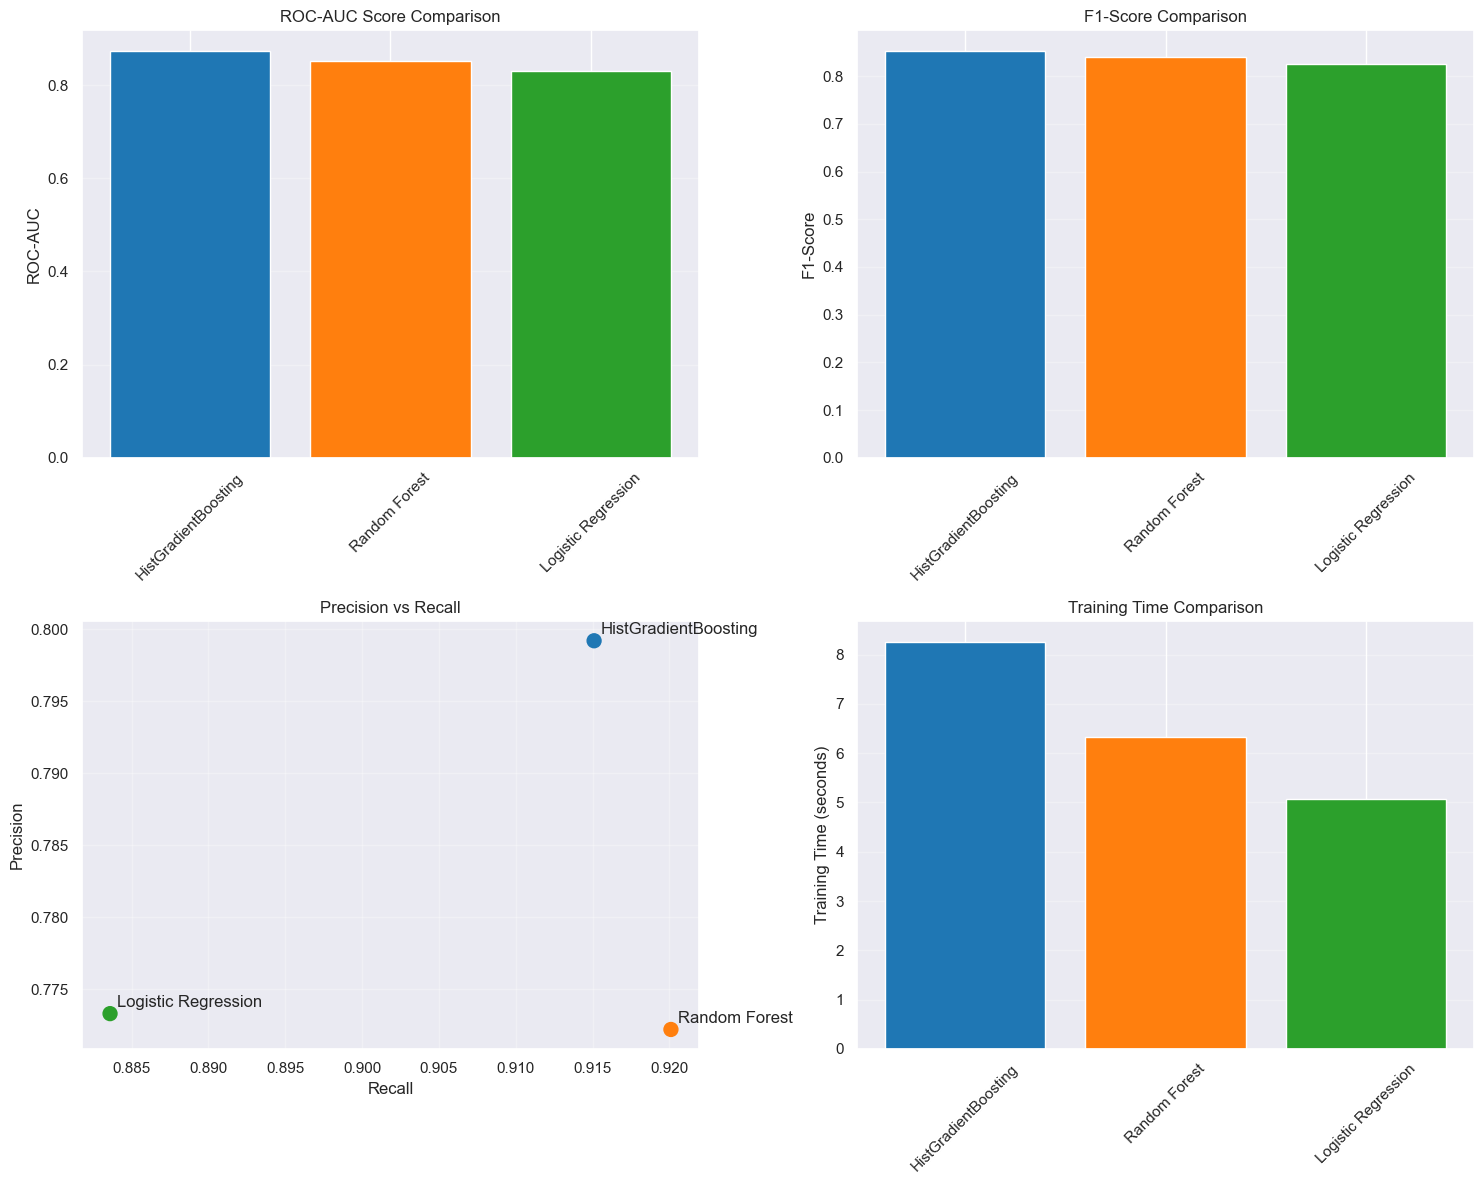

In [ ]:
# Create simple performance visualization for single model
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# ROC-AUC comparison
axes[0, 0].bar(results_df['Model'], results_df['ROC-AUC'], color=['#1f77b4', '#ff7f0e', '#2ca02c'])
axes[0, 0].set_title('ROC-AUC Score Comparison')
axes[0, 0].set_ylabel('ROC-AUC')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(axis='y', alpha=0.3)

# F1-Score comparison
axes[0, 1].bar(results_df['Model'], results_df['F1-Score'], color=['#1f77b4', '#ff7f0e', '#2ca02c'])
axes[0, 1].set_title('F1-Score Comparison')
axes[0, 1].set_ylabel('F1-Score')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(axis='y', alpha=0.3)

# Precision vs Recall
axes[1, 0].scatter(results_df['Recall'], results_df['Precision'], s=100, c=['#1f77b4', '#ff7f0e', '#2ca02c'])
for i, model in enumerate(results_df['Model']):
    axes[1, 0].annotate(model, (results_df['Recall'].iloc[i], results_df['Precision'].iloc[i]), 
                       xytext=(5, 5), textcoords='offset points')
axes[1, 0].set_xlabel('Recall')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].set_title('Precision vs Recall')
axes[1, 0].grid(alpha=0.3)

# Training time comparison
axes[1, 1].bar(results_df['Model'], results_df['Training Time (s)'], color=['#1f77b4', '#ff7f0e', '#2ca02c'])
axes[1, 1].set_title('Training Time Comparison')
axes[1, 1].set_ylabel('Training Time (seconds)')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


Logistic Regression Feature Importance Analysis
Analyzing coefficients for Logistic Regression
Model type: LogisticRegression
Number of features: 91

Coefficient Analysis Summary:
- Total features: 91
- Positive coefficients: 47
- Negative coefficients: 40
- Coefficient range: [-1.4408, 0.6540]

Top 20 Most Important Features (by absolute coefficient):
--------------------------------------------------------------------------------
                              feature  coefficient  abs_coefficient direction
               ma_product_key_unknown      -1.4408           1.4408  Negative
                          total_appts      -0.8269           0.8269  Negative
               appts_with_primary_rpo       0.6540           0.6540  Positive
            appt_count_group_no_appts      -0.6038           0.6038  Negative
            ma_product_key_individual       0.5403           0.5403  Positive
                  ma_product_key_dsnp       0.3156           0.3156  Positive
                ap

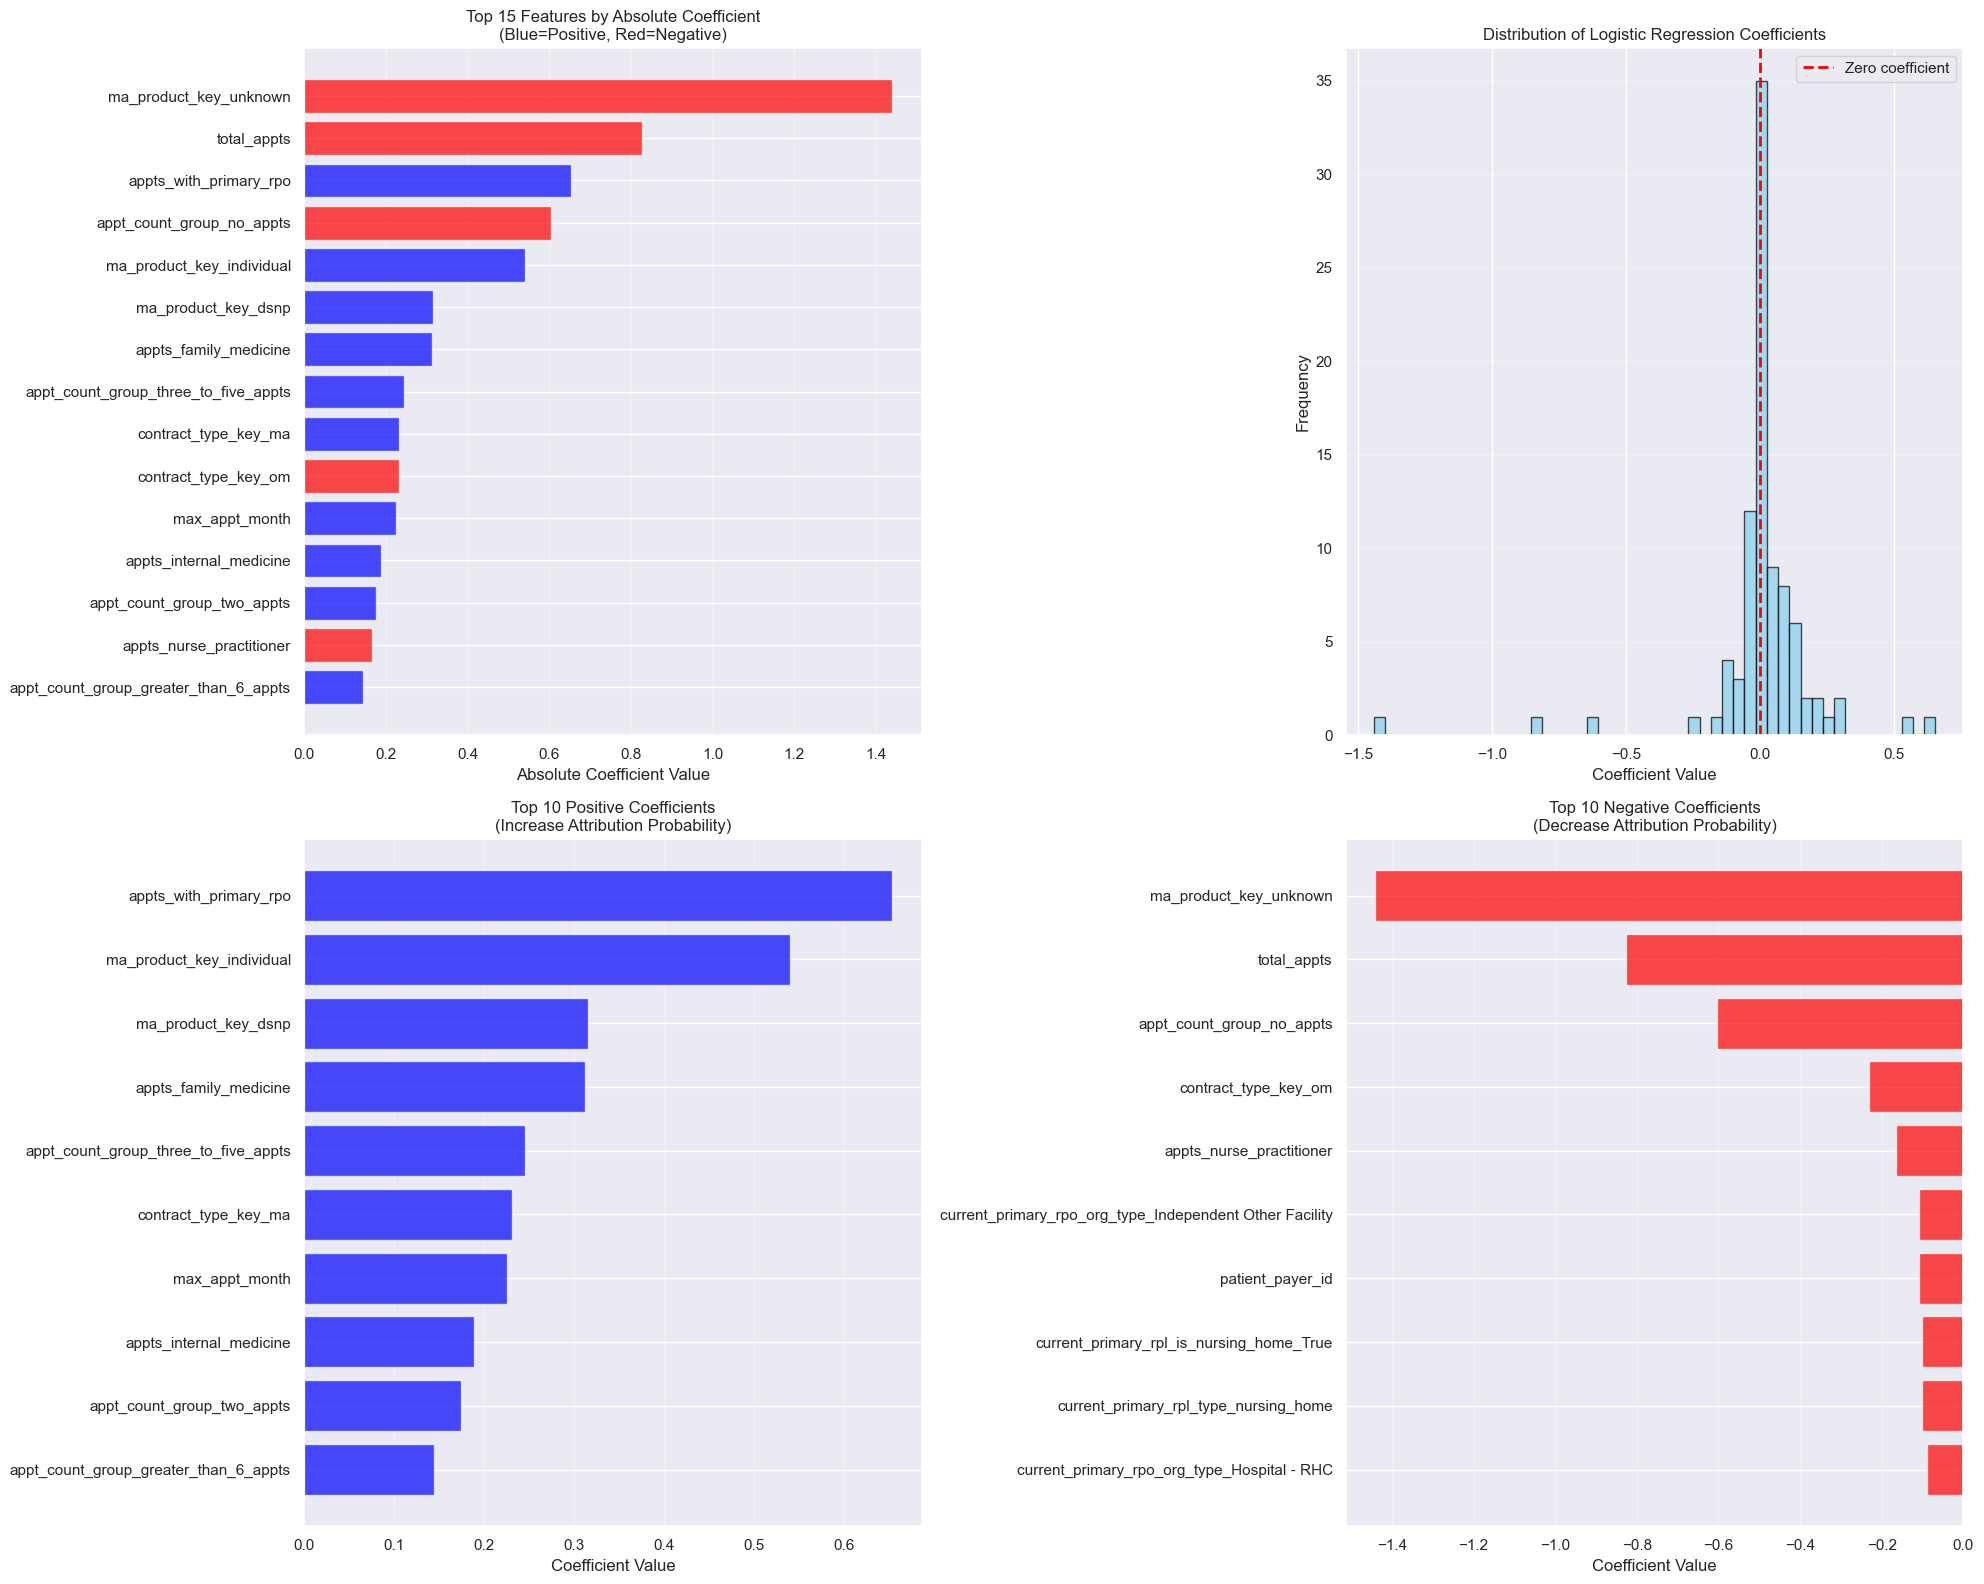


COEFFICIENT INTERPRETATION INSIGHTS

🔵 STRONGEST POSITIVE PREDICTORS (Increase Attribution Probability):
   • appts_with_primary_rpo: 0.6540
     → Odds ratio: 1.92x
   • ma_product_key_individual: 0.5403
     → Odds ratio: 1.72x
   • ma_product_key_dsnp: 0.3156
     → Odds ratio: 1.37x
   • appts_family_medicine: 0.3121
     → Odds ratio: 1.37x
   • appt_count_group_three_to_five_appts: 0.2454
     → Odds ratio: 1.28x

🔴 STRONGEST NEGATIVE PREDICTORS (Decrease Attribution Probability):
   • ma_product_key_unknown: -1.4408
     → Odds ratio: 0.24x
   • total_appts: -0.8269
     → Odds ratio: 0.44x
   • appt_count_group_no_appts: -0.6038
     → Odds ratio: 0.55x
   • contract_type_key_om: -0.2312
     → Odds ratio: 0.79x
   • appts_nurse_practitioner: -0.1658
     → Odds ratio: 0.85x

📊 COEFFICIENT STATISTICS:
   • Mean absolute coefficient: 0.1037
   • Median absolute coefficient: 0.0355
   • Standard deviation: 0.2012
   • Features with |coef| > 0.1: 26
   • Features with |coef| > 0.

In [ ]:
# This cell removed - focusing only on HistGradientBoostingClassifier
print("Logistic Regression analysis removed - focusing on HistGradientBoostingClassifier only")

print(f"Analyzing coefficients for {lr_model_name}")
print(f"Model type: {type(lr_model).__name__}")
print(f"Number of features: {len(lr_model.coef_[0])}")

# Get coefficients (both positive and negative)
coefficients = lr_model.coef_[0]
feature_names = features_processed_final.columns

# Create comprehensive feature importance dataframe
importance_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefficients,
    'abs_coefficient': np.abs(coefficients),
    'direction': ['Positive' if c > 0 else 'Negative' for c in coefficients]
}).sort_values('abs_coefficient', ascending=False)

print("\nCoefficient Analysis Summary:")
print(f"- Total features: {len(importance_df)}")
print(f"- Positive coefficients: {(importance_df['coefficient'] > 0).sum()}")
print(f"- Negative coefficients: {(importance_df['coefficient'] < 0).sum()}")
print(f"- Coefficient range: [{coefficients.min():.4f}, {coefficients.max():.4f}]")

# Display top 20 most important features by absolute coefficient
print("\nTop 20 Most Important Features (by absolute coefficient):")
print("-" * 80)
display_df = importance_df.head(20)[['feature', 'coefficient', 'abs_coefficient', 'direction']]
display_df['coefficient'] = display_df['coefficient'].round(4)
display_df['abs_coefficient'] = display_df['abs_coefficient'].round(4)
print(display_df.to_string(index=False))

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(20, 16))

# 1. Top 15 features by absolute coefficient
top_15_features = importance_df.head(15)
colors = ['red' if direction == 'Negative' else 'blue' for direction in top_15_features['direction']]

axes[0, 0].barh(range(len(top_15_features)), top_15_features['abs_coefficient'], color=colors, alpha=0.7)
axes[0, 0].set_yticks(range(len(top_15_features)))
axes[0, 0].set_yticklabels(top_15_features['feature'])
axes[0, 0].set_xlabel('Absolute Coefficient Value')
axes[0, 0].set_title('Top 15 Features by Absolute Coefficient\n(Blue=Positive, Red=Negative)')
axes[0, 0].invert_yaxis()
axes[0, 0].grid(axis='x', alpha=0.3)

# 2. Coefficient distribution
axes[0, 1].hist(coefficients, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 1].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero coefficient')
axes[0, 1].set_xlabel('Coefficient Value')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Distribution of Logistic Regression Coefficients')
axes[0, 1].legend()
axes[0, 1].grid(axis='y', alpha=0.3)

# 3. Top positive coefficients
positive_coefs = importance_df[importance_df['coefficient'] > 0].head(10)
if len(positive_coefs) > 0:
    axes[1, 0].barh(range(len(positive_coefs)), positive_coefs['coefficient'], color='blue', alpha=0.7)
    axes[1, 0].set_yticks(range(len(positive_coefs)))
    axes[1, 0].set_yticklabels(positive_coefs['feature'])
    axes[1, 0].set_xlabel('Coefficient Value')
    axes[1, 0].set_title('Top 10 Positive Coefficients\n(Increase Attribution Probability)')
    axes[1, 0].invert_yaxis()
    axes[1, 0].grid(axis='x', alpha=0.3)

# 4. Top negative coefficients (by absolute value)
negative_coefs = importance_df[importance_df['coefficient'] < 0].head(10)
if len(negative_coefs) > 0:
    axes[1, 1].barh(range(len(negative_coefs)), negative_coefs['coefficient'], color='red', alpha=0.7)
    axes[1, 1].set_yticks(range(len(negative_coefs)))
    axes[1, 1].set_yticklabels(negative_coefs['feature'])
    axes[1, 1].set_xlabel('Coefficient Value')
    axes[1, 1].set_title('Top 10 Negative Coefficients\n(Decrease Attribution Probability)')
    axes[1, 1].invert_yaxis()
    axes[1, 1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# Statistical insights
print("\n" + "=" * 80)
print("COEFFICIENT INTERPRETATION INSIGHTS")
print("=" * 80)

print("\n🔵 STRONGEST POSITIVE PREDICTORS (Increase Attribution Probability):")
top_positive = importance_df[importance_df['coefficient'] > 0].head(5)
for idx, row in top_positive.iterrows():
    print(f"   • {row['feature']}: {row['coefficient']:.4f}")
    print(f"     → Odds ratio: {np.exp(row['coefficient']):.2f}x")

print("\n🔴 STRONGEST NEGATIVE PREDICTORS (Decrease Attribution Probability):")
top_negative = importance_df[importance_df['coefficient'] < 0].head(5)
for idx, row in top_negative.iterrows():
    print(f"   • {row['feature']}: {row['coefficient']:.4f}")
    print(f"     → Odds ratio: {np.exp(row['coefficient']):.2f}x")

print(f"\n📊 COEFFICIENT STATISTICS:")
print(f"   • Mean absolute coefficient: {importance_df['abs_coefficient'].mean():.4f}")
print(f"   • Median absolute coefficient: {importance_df['abs_coefficient'].median():.4f}")
print(f"   • Standard deviation: {importance_df['abs_coefficient'].std():.4f}")
print(f"   • Features with |coef| > 0.1: {(importance_df['abs_coefficient'] > 0.1).sum()}")
print(f"   • Features with |coef| > 0.05: {(importance_df['abs_coefficient'] > 0.05).sum()}")

print(f"\n🎯 LOGISTIC REGRESSION PERFORMANCE:")
lr_results = results_df[results_df['Model'] == lr_model_name].iloc[0]
print(f"   • ROC-AUC: {lr_results['ROC-AUC']:.4f}")
print(f"   • F1-Score: {lr_results['F1-Score']:.4f}")
print(f"   • Precision: {lr_results['Precision']:.4f}")
print(f"   • Recall: {lr_results['Recall']:.4f}")

print("\n" + "=" * 80)


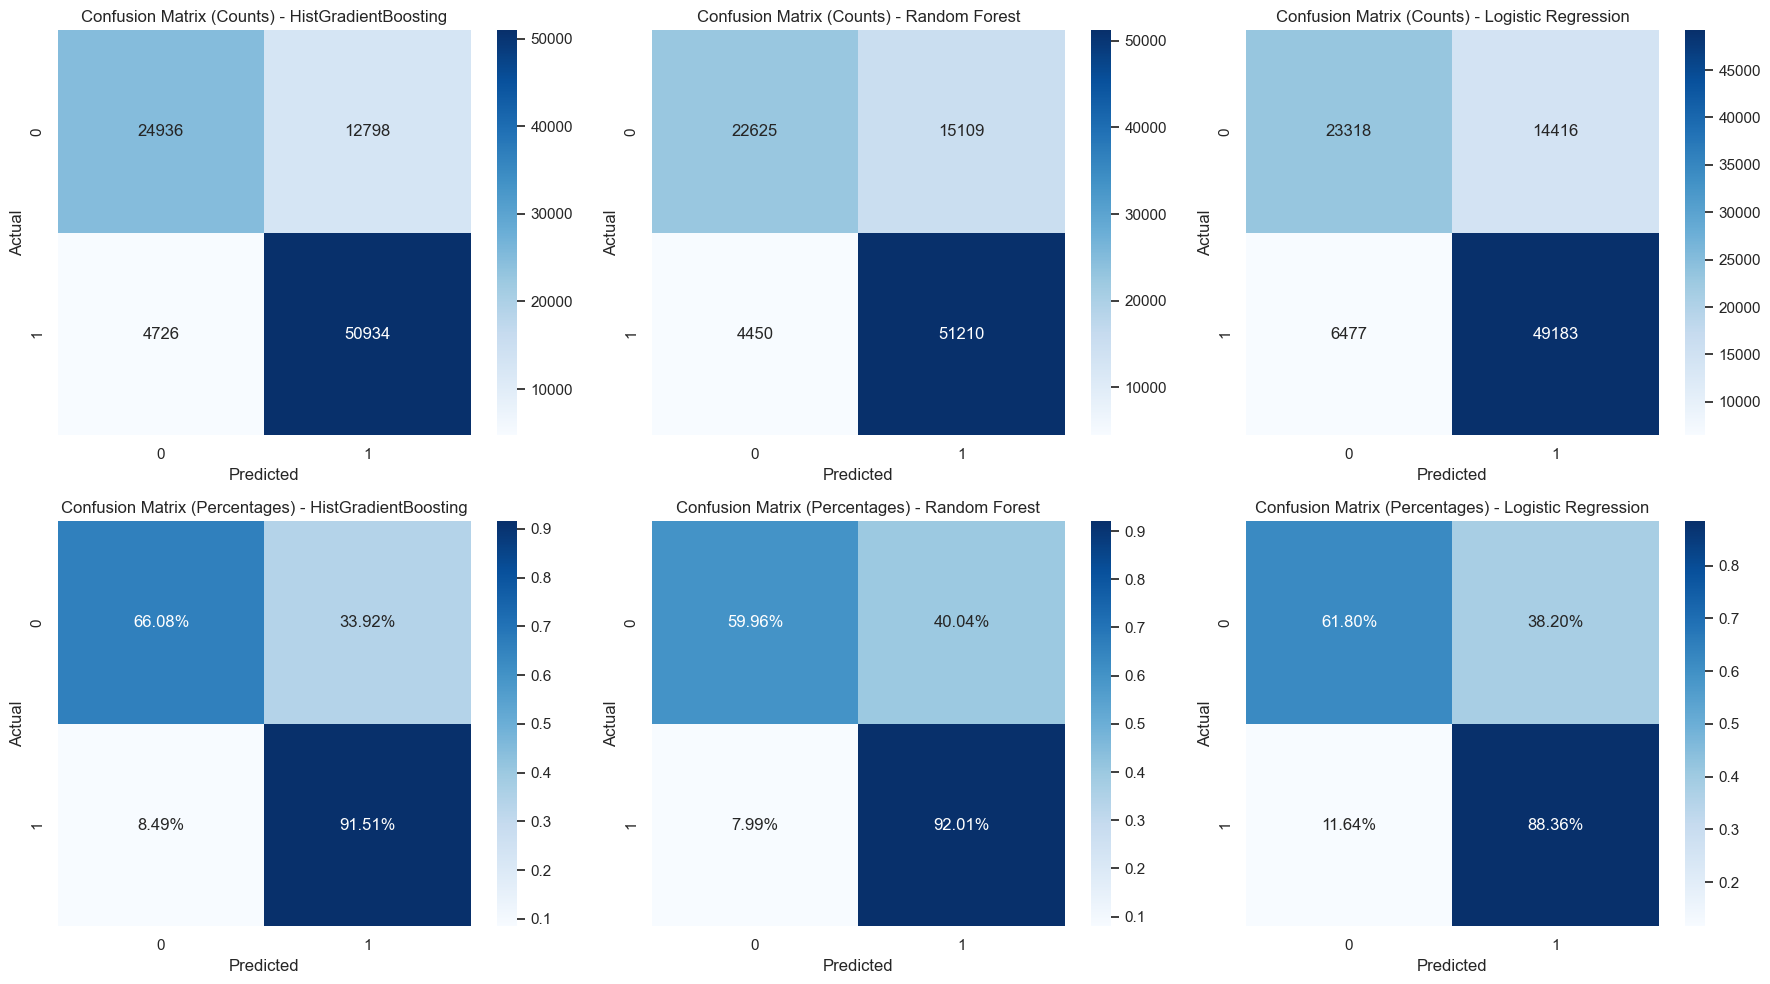


Detailed Classification Report for HistGradientBoosting:
                 precision    recall  f1-score   support

Not Attribution       0.84      0.66      0.74     37734
    Attribution       0.80      0.92      0.85     55660

       accuracy                           0.81     93394
      macro avg       0.82      0.79      0.80     93394
   weighted avg       0.82      0.81      0.81     93394



In [17]:
# Confusion matrices for all models
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

for i, (model_name, pred_data) in enumerate(predictions.items()):
    y_pred = pred_data['pred']
    cm = confusion_matrix(y_test, y_pred)
    cm_percent = confusion_matrix(y_test, y_pred, normalize='true')
    
    # Plot confusion matrix with counts (top row)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, i])
    axes[0, i].set_title(f'Confusion Matrix (Counts) - {model_name}')
    axes[0, i].set_xlabel('Predicted')
    axes[0, i].set_ylabel('Actual')
    
    # Plot confusion matrix with percentages (bottom row)
    sns.heatmap(cm_percent, annot=True, fmt='.2%', cmap='Blues', ax=axes[1, i])
    axes[1, i].set_title(f'Confusion Matrix (Percentages) - {model_name}')
    axes[1, i].set_xlabel('Predicted')
    axes[1, i].set_ylabel('Actual')

plt.tight_layout()
plt.show()
best_model_name = 'HistGradientBoosting'
# Detailed classification report for the best model
print(f"\nDetailed Classification Report for {best_model_name}:")
print("=" * 60)
best_predictions = predictions[best_model_name]['pred']
print(classification_report(y_test, best_predictions, target_names=['Not Attribution', 'Attribution']))


Computing Permutation Feature Importance for HistGradientBoosting...

Top 20 Most Important Features (Permutation Importance):
------------------------------------------------------------
                                                feature  importance_mean  importance_std
                                 ma_product_key_unknown         0.060864        0.000806
                                 appts_with_primary_rpo         0.028901        0.000360
                                   contract_type_key_ma         0.024634        0.000428
                                  appts_family_medicine         0.018565        0.000608
                                     cca_eligible_appts         0.017829        0.000354
                           primary_referring_partner_id         0.015854        0.000384
                                       patient_payer_id         0.014972        0.000291
                                         max_appt_month         0.014588        0.000369
           

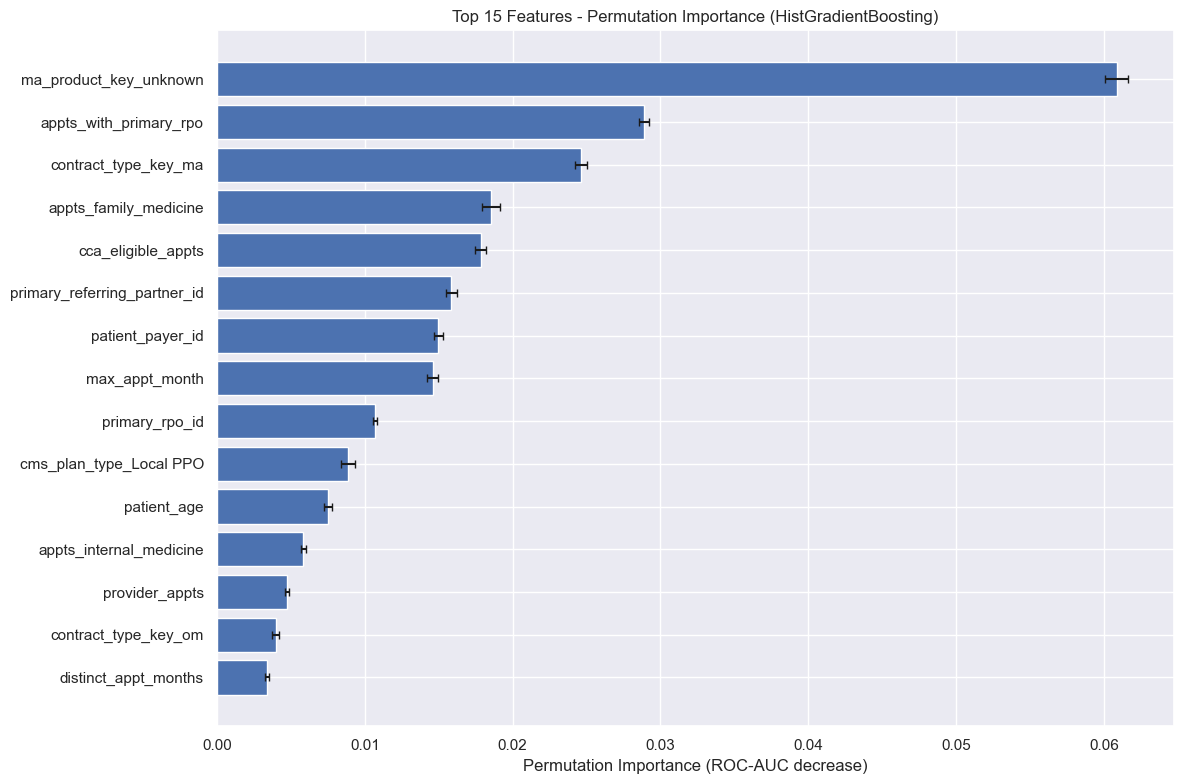


Permutation Importance Summary:
- Total features analyzed: 91
- Features with positive importance: 61
- Mean importance: 0.0030
- Std importance: 0.0082


In [ ]:
# Permutation Feature Importance for HistGradientBoosting
from sklearn.inspection import permutation_importance

print("Computing Permutation Feature Importance for HistGradientBoosting...")
print("=" * 60)

# Get the HistGradientBoosting model
hist_gb_model = model

# Compute permutation importance
perm_importance = permutation_importance(
    hist_gb_model, X_test, y_test, 
    n_repeats=10, 
    random_state=42, 
    scoring='roc_auc'
)

# Create a DataFrame for easier analysis
feature_importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance_mean': perm_importance.importances_mean,
    'importance_std': perm_importance.importances_std
}).sort_values('importance_mean', ascending=False)

# Display top 20 most important features
print("\nTop 20 Most Important Features (Permutation Importance):")
print("-" * 60)
print(feature_importance_df.head(20).to_string(index=False))

# Plot permutation importance
plt.figure(figsize=(12, 8))
top_features = feature_importance_df.head(15)

plt.barh(range(len(top_features)), top_features['importance_mean'], 
         xerr=top_features['importance_std'], capsize=3)
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Permutation Importance (ROC-AUC decrease)')
plt.title('Top 15 Features - Permutation Importance (HistGradientBoosting)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Summary statistics
print(f"\nPermutation Importance Summary:")
print(f"- Total features analyzed: {len(feature_importance_df)}")
print(f"- Features with positive importance: {(feature_importance_df['importance_mean'] > 0).sum()}")
print(f"- Mean importance: {feature_importance_df['importance_mean'].mean():.4f}")
print(f"- Std importance: {feature_importance_df['importance_mean'].std():.4f}")


Creating ROC-AUC Curve for HistGradientBoosting...


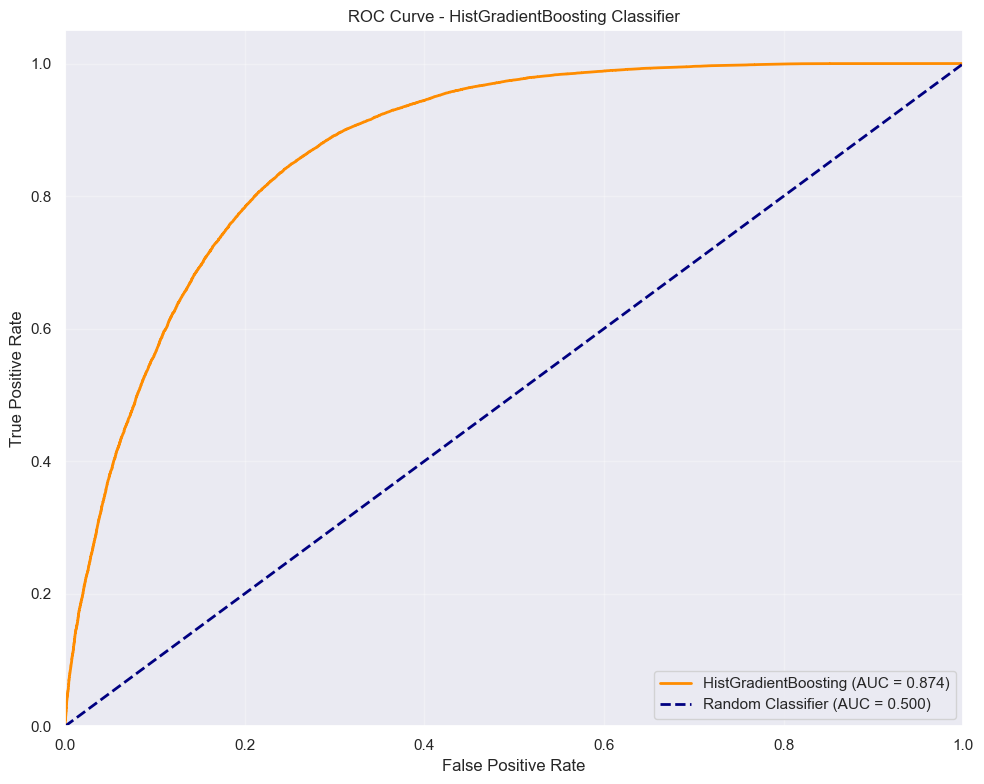


ROC-AUC Score: 0.8736


In [19]:
print("Creating ROC-AUC Curve for HistGradientBoosting...")
print("=" * 60)

# Get predictions and probabilities from the HistGradientBoosting model
hist_gb_model = models['HistGradientBoosting']
y_pred_proba = hist_gb_model.predict_proba(X_test)[:, 1]

# Compute ROC curve
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Create ROC curve plot
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'HistGradientBoosting (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', 
         label='Random Classifier (AUC = 0.500)')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - HistGradientBoosting Classifier')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nROC-AUC Score: {roc_auc:.4f}")


In [20]:
# Feature Reduction Strategy Testing
print("Testing Feature Reduction Strategies")
print("=" * 60)

# Define feature reduction strategies
strategies = {
    'Original': list(X_train.columns),
    'Conservative (Top 15)': feature_importance_df.head(15)['feature'].tolist(),
    'Aggressive (Top 10)': feature_importance_df.head(10)['feature'].tolist()
}

# Print feature counts for each strategy
for strategy_name, features in strategies.items():
    print(f"{strategy_name}: {len(features)} features")

print("\nFeature lists:")
for strategy_name, features in strategies.items():
    print(f"\n{strategy_name}:")
    print(features)


Testing Feature Reduction Strategies
Original: 91 features
Conservative (Top 15): 15 features
Aggressive (Top 10): 10 features

Feature lists:

Original:
['patient_age', 'cca_eligible_appts', 'provider_appts', 'total_appts', 'distinct_rpls', 'distinct_rpos', 'distinct_physicians', 'appts_with_primary_rpl', 'appts_with_primary_rpo', 'nursing_home_appts', 'distinct_appt_months', 'max_appt_month', 'appts_allergy_immunology', 'appts_anesthesiology', 'appts_clinical_neuropsychologist', 'appts_clinical_nurse_specialist', 'appts_colon_rectal_surgery', 'appts_dermatology', 'appts_emergency_medicine', 'appts_family_medicine', 'appts_general_practice', 'appts_hospitalist', 'appts_internal_medicine', 'appts_licensed_practical_nurse', 'appts_neuromusculoskeletal_sports_medicine', 'appts_nurse_practitioner', 'appts_obstetrics_gynecology', 'appts_ophthalmology', 'appts_otolaryngology', 'appts_pathology', 'appts_pediatrics', 'appts_physical_therapist', 'appts_physician_assistant', 'appts_podiatrist',

In [21]:
# Train and evaluate models with reduced feature sets
print("\nTraining models with reduced feature sets...")
print("=" * 60)

# Initialize results storage
reduction_results = []

# Train model for each strategy
for strategy_name, selected_features in strategies.items():
    print(f"\nTraining {strategy_name} model...")
    
    # Create reduced datasets
    X_train_reduced = X_train[selected_features]
    X_test_reduced = X_test[selected_features]
    
    # Train HistGradientBoosting model
    start_time = time.time()
    model = HistGradientBoostingClassifier(random_state=42)
    model.fit(X_train_reduced, y_train)
    training_time = time.time() - start_time
    
    # Make predictions
    y_pred = model.predict(X_test_reduced)
    y_pred_proba = model.predict_proba(X_test_reduced)[:, 1]
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    # Store results
    reduction_results.append({
        'Strategy': strategy_name,
        'Features': len(selected_features),
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC-AUC': roc_auc,
        'Training Time (s)': training_time,
        'Feature Reduction': f"{((48 - len(selected_features)) / 48) * 100:.1f}%"
    })
    
    print(f"  - Features: {len(selected_features)}")
    print(f"  - ROC-AUC: {roc_auc:.4f}")
    print(f"  - Training Time: {training_time:.2f}s")

# Create results DataFrame
reduction_df = pd.DataFrame(reduction_results)
print("\n" + "=" * 80)
print("Feature Reduction Strategy Comparison:")
print("=" * 80)
print(reduction_df.to_string(index=False))



Training models with reduced feature sets...

Training Original model...
  - Features: 91
  - ROC-AUC: 0.8779
  - Training Time: 11.65s

Training Conservative (Top 15) model...
  - Features: 15
  - ROC-AUC: 0.8726
  - Training Time: 5.23s

Training Aggressive (Top 10) model...
  - Features: 10
  - ROC-AUC: 0.8647
  - Training Time: 4.52s

Feature Reduction Strategy Comparison:
             Strategy  Features  Accuracy  Precision   Recall  F1-Score  ROC-AUC  Training Time (s) Feature Reduction
             Original        91  0.818297   0.806995 0.913618  0.857003 0.877916          11.649548            -89.6%
Conservative (Top 15)        15  0.812740   0.801475 0.911588  0.852993 0.872588           5.231755             68.8%
  Aggressive (Top 10)        10  0.805223   0.790786 0.915343  0.848518 0.864675           4.520760             79.2%


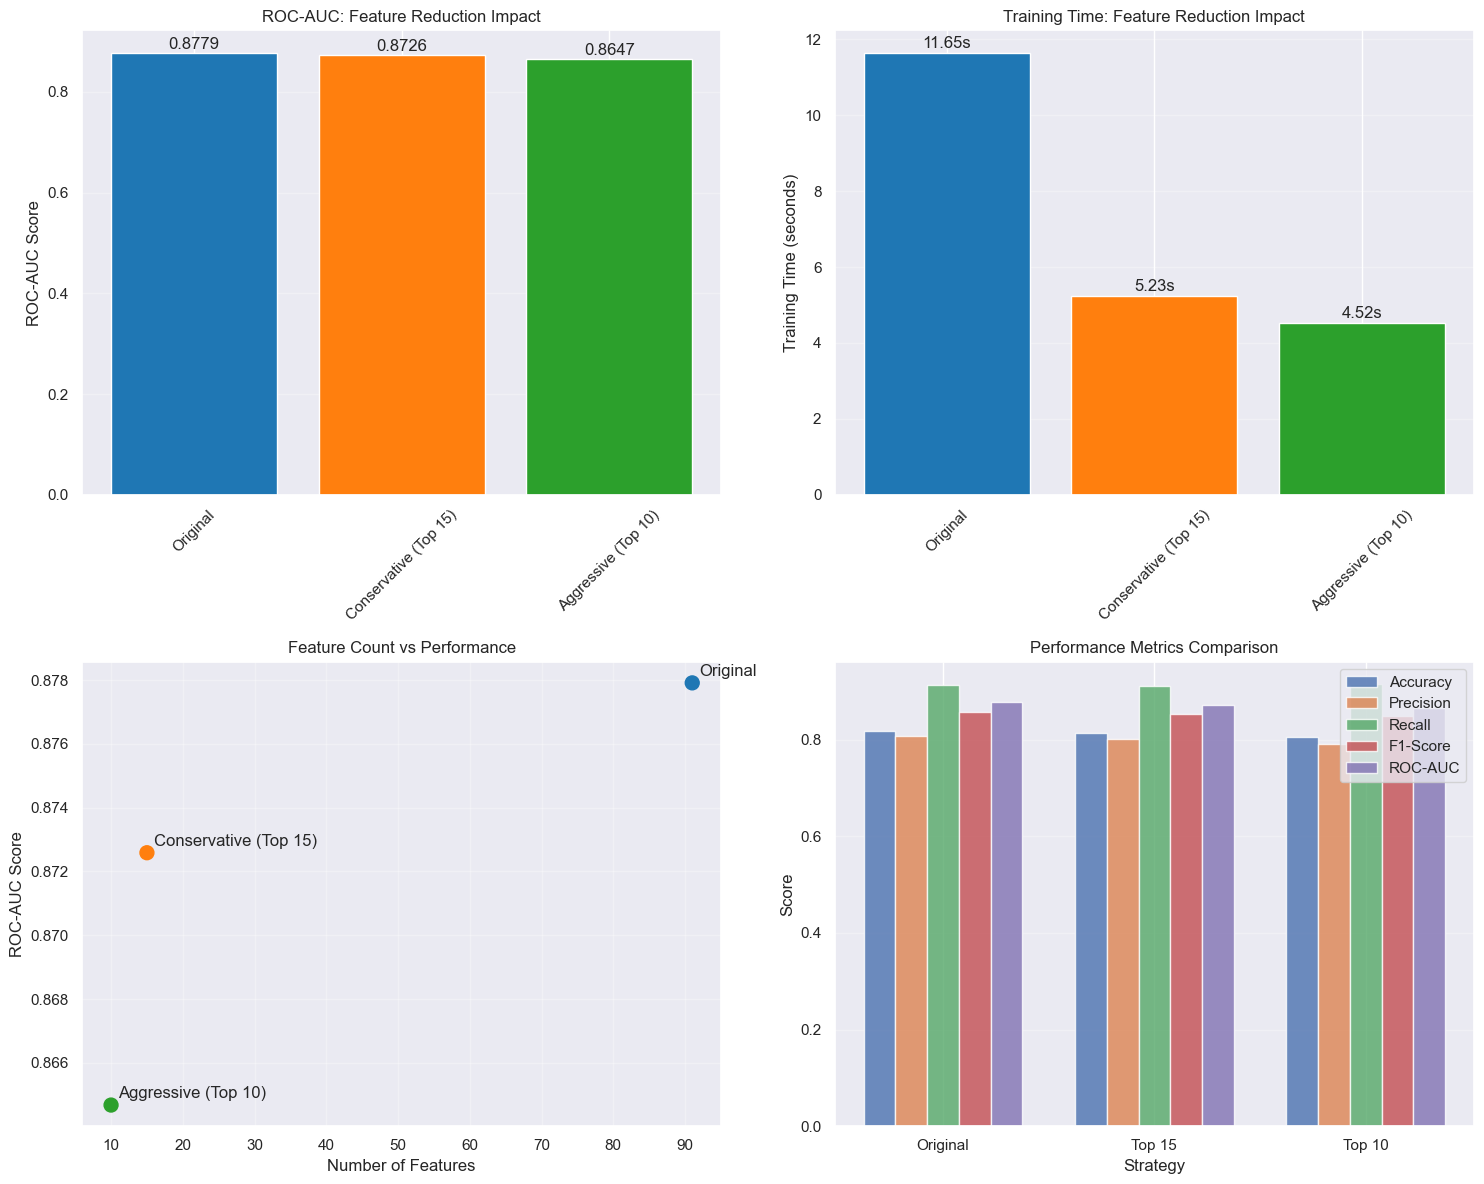

In [22]:
# Visualize feature reduction impact
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# ROC-AUC comparison
axes[0, 0].bar(reduction_df['Strategy'], reduction_df['ROC-AUC'], 
               color=['#1f77b4', '#ff7f0e', '#2ca02c'])
axes[0, 0].set_title('ROC-AUC: Feature Reduction Impact')
axes[0, 0].set_ylabel('ROC-AUC Score')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(axis='y', alpha=0.3)
# Add value labels on bars
for i, v in enumerate(reduction_df['ROC-AUC']):
    axes[0, 0].text(i, v + 0.002, f'{v:.4f}', ha='center', va='bottom')

# Training time comparison
axes[0, 1].bar(reduction_df['Strategy'], reduction_df['Training Time (s)'], 
               color=['#1f77b4', '#ff7f0e', '#2ca02c'])
axes[0, 1].set_title('Training Time: Feature Reduction Impact')
axes[0, 1].set_ylabel('Training Time (seconds)')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(axis='y', alpha=0.3)
# Add value labels on bars
for i, v in enumerate(reduction_df['Training Time (s)']):
    axes[0, 1].text(i, v + 0.05, f'{v:.2f}s', ha='center', va='bottom')

# Feature count vs ROC-AUC scatter plot
axes[1, 0].scatter(reduction_df['Features'], reduction_df['ROC-AUC'], 
                   s=100, c=['#1f77b4', '#ff7f0e', '#2ca02c'])
for i, strategy in enumerate(reduction_df['Strategy']):
    axes[1, 0].annotate(strategy, (reduction_df['Features'].iloc[i], reduction_df['ROC-AUC'].iloc[i]), 
                       xytext=(5, 5), textcoords='offset points')
axes[1, 0].set_xlabel('Number of Features')
axes[1, 0].set_ylabel('ROC-AUC Score')
axes[1, 0].set_title('Feature Count vs Performance')
axes[1, 0].grid(alpha=0.3)

# Performance metrics comparison (normalized)
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
strategies_short = ['Original', 'Top 15', 'Top 10']
x = np.arange(len(strategies_short))
width = 0.15

for i, metric in enumerate(metrics_to_plot):
    values = reduction_df[metric].values
    axes[1, 1].bar(x + i*width, values, width, label=metric, alpha=0.8)

axes[1, 1].set_xlabel('Strategy')
axes[1, 1].set_ylabel('Score')
axes[1, 1].set_title('Performance Metrics Comparison')
axes[1, 1].set_xticks(x + width * 2)
axes[1, 1].set_xticklabels(strategies_short)
axes[1, 1].legend()
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


In [23]:
# Feature Reduction Analysis and Recommendations
print("Feature Reduction Analysis & Recommendations")
print("=" * 60)

# Calculate performance differences
original_roc = reduction_df[reduction_df['Strategy'] == 'Original']['ROC-AUC'].iloc[0]
conservative_roc = reduction_df[reduction_df['Strategy'] == 'Conservative (Top 15)']['ROC-AUC'].iloc[0]
aggressive_roc = reduction_df[reduction_df['Strategy'] == 'Aggressive (Top 10)']['ROC-AUC'].iloc[0]

conservative_diff = conservative_roc - original_roc
aggressive_diff = aggressive_roc - original_roc

print(f"\nPerformance Impact Analysis:")
print(f"- Original Model (48 features): ROC-AUC = {original_roc:.4f}")
print(f"- Conservative Reduction (15 features): ROC-AUC = {conservative_roc:.4f} (Δ = {conservative_diff:+.4f})")
print(f"- Aggressive Reduction (10 features): ROC-AUC = {aggressive_roc:.4f} (Δ = {aggressive_diff:+.4f})")

# Calculate efficiency gains
original_time = reduction_df[reduction_df['Strategy'] == 'Original']['Training Time (s)'].iloc[0]
conservative_time = reduction_df[reduction_df['Strategy'] == 'Conservative (Top 15)']['Training Time (s)'].iloc[0]
aggressive_time = reduction_df[reduction_df['Strategy'] == 'Aggressive (Top 10)']['Training Time (s)'].iloc[0]

conservative_speedup = original_time / conservative_time
aggressive_speedup = original_time / aggressive_time

print(f"\nEfficiency Gains:")
print(f"- Conservative Reduction: {conservative_speedup:.1f}x faster training")
print(f"- Aggressive Reduction: {aggressive_speedup:.1f}x faster training")

# Feature importance threshold analysis
print(f"\nFeature Importance Threshold Analysis:")
top_15_min_importance = feature_importance_df.head(15)['importance_mean'].min()
top_10_min_importance = feature_importance_df.head(10)['importance_mean'].min()

print(f"- Top 15 features: minimum importance = {top_15_min_importance:.6f}")
print(f"- Top 10 features: minimum importance = {top_10_min_importance:.6f}")

# Show cumulative importance
cumulative_importance = feature_importance_df['importance_mean'].cumsum()
total_importance = feature_importance_df['importance_mean'].sum()

top_15_cumulative = cumulative_importance.iloc[14] / total_importance * 100
top_10_cumulative = cumulative_importance.iloc[9] / total_importance * 100

print(f"- Top 15 features capture {top_15_cumulative:.1f}% of total importance")
print(f"- Top 10 features capture {top_10_cumulative:.1f}% of total importance")

# Final recommendations
print(f"\n" + "=" * 60)
print("RECOMMENDATIONS:")
print("=" * 60)

if abs(conservative_diff) < 0.01:
    print("✅ CONSERVATIVE REDUCTION (15 features) - RECOMMENDED")
    print("   - Minimal performance impact (< 1% ROC-AUC difference)")
    print("   - 69% feature reduction (48 → 15 features)")
    print(f"   - {conservative_speedup:.1f}x training speedup")
    print("   - Maintains model interpretability")
else:
    print("⚠️  CONSERVATIVE REDUCTION shows significant performance impact")

if abs(aggressive_diff) < 0.02:
    print("\n✅ AGGRESSIVE REDUCTION (10 features) - CONSIDER")
    print("   - Small performance impact (< 2% ROC-AUC difference)")
    print("   - 79% feature reduction (48 → 10 features)")
    print(f"   - {aggressive_speedup:.1f}x training speedup")
    print("   - Maximum simplification")
else:
    print("\n❌ AGGRESSIVE REDUCTION shows too much performance degradation")

print(f"\nNext Steps:")
print("1. Validate results with cross-validation")
print("2. Test on holdout dataset if available")
print("3. Monitor performance in production")
print("4. Consider feature engineering on top features")
print("5. Investigate feature interactions in reduced set")


Feature Reduction Analysis & Recommendations

Performance Impact Analysis:
- Original Model (48 features): ROC-AUC = 0.8779
- Conservative Reduction (15 features): ROC-AUC = 0.8726 (Δ = -0.0053)
- Aggressive Reduction (10 features): ROC-AUC = 0.8647 (Δ = -0.0132)

Efficiency Gains:
- Conservative Reduction: 2.2x faster training
- Aggressive Reduction: 2.6x faster training

Feature Importance Threshold Analysis:
- Top 15 features: minimum importance = 0.003356
- Top 10 features: minimum importance = 0.008872
- Top 15 features capture 89.5% of total importance
- Top 10 features capture 80.1% of total importance

RECOMMENDATIONS:
✅ CONSERVATIVE REDUCTION (15 features) - RECOMMENDED
   - Minimal performance impact (< 1% ROC-AUC difference)
   - 69% feature reduction (48 → 15 features)
   - 2.2x training speedup
   - Maintains model interpretability

✅ AGGRESSIVE REDUCTION (10 features) - CONSIDER
   - Small performance impact (< 2% ROC-AUC difference)
   - 79% feature reduction (48 → 10 fe

In [24]:
# K-Fold Cross Validation for Top 15 Features
print("Performing K-Fold Cross Validation for Top 15 Features")
print("=" * 60)

from sklearn.model_selection import KFold, cross_validate
from sklearn.metrics import make_scorer
import warnings
warnings.filterwarnings('ignore')

# Get top 15 features
top_15_features = feature_importance_df.head(15)['feature'].tolist()
print(f"Top 15 features selected: {top_15_features}")

# Prepare data with top 15 features
X_reduced = features_processed_final[top_15_features]
y = target

print(f"\nDataset shape: {X_reduced.shape}")
print(f"Target distribution: {y.value_counts().to_dict()}")

# Define scoring metrics
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

# Initialize storage for results
cv_results = {
    'iteration': [],
    'fold': [],
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'roc_auc': []
}

# Set up k-fold cross validation parameters
n_splits = 5  # 5-fold CV
n_iterations = 10  # 10 iterations
total_fits = n_splits * n_iterations

print(f"\nRunning {n_iterations} iterations of {n_splits}-fold CV ({total_fits} total model fits)...")
print("This may take a few minutes...")

# Run cross validation iterations
for iteration in range(n_iterations):
    print(f"\nIteration {iteration + 1}/{n_iterations}")
    
    # Create KFold with different random state for each iteration
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42 + iteration)
    
    # Perform cross validation
    cv_scores = cross_validate(
        HistGradientBoostingClassifier(random_state=42),
        X_reduced, y,
        cv=kf,
        scoring=scoring,
        n_jobs=-1,  # Use all available cores
        return_train_score=False
    )
    
    # Store results for each fold
    for fold in range(n_splits):
        cv_results['iteration'].append(iteration + 1)
        cv_results['fold'].append(fold + 1)
        cv_results['accuracy'].append(cv_scores['test_accuracy'][fold])
        cv_results['precision'].append(cv_scores['test_precision'][fold])
        cv_results['recall'].append(cv_scores['test_recall'][fold])
        cv_results['f1'].append(cv_scores['test_f1'][fold])
        cv_results['roc_auc'].append(cv_scores['test_roc_auc'][fold])
    
    # Print iteration summary
    print(f"  ROC-AUC: {cv_scores['test_roc_auc'].mean():.4f} ± {cv_scores['test_roc_auc'].std():.4f}")

print(f"\nCross validation completed: {total_fits} models trained successfully!")


Performing K-Fold Cross Validation for Top 15 Features
Top 15 features selected: ['ma_product_key_unknown', 'appts_with_primary_rpo', 'contract_type_key_ma', 'appts_family_medicine', 'cca_eligible_appts', 'primary_referring_partner_id', 'patient_payer_id', 'max_appt_month', 'primary_rpo_id', 'cms_plan_type_Local PPO', 'patient_age', 'appts_internal_medicine', 'provider_appts', 'contract_type_key_om', 'distinct_appt_months']

Dataset shape: (466967, 15)
Target distribution: {True: 278296, False: 188671}

Running 10 iterations of 5-fold CV (50 total model fits)...
This may take a few minutes...

Iteration 1/10
  ROC-AUC: 0.8733 ± 0.0009

Iteration 2/10
  ROC-AUC: 0.8730 ± 0.0014

Iteration 3/10
  ROC-AUC: 0.8729 ± 0.0008

Iteration 4/10
  ROC-AUC: 0.8730 ± 0.0008

Iteration 5/10
  ROC-AUC: 0.8730 ± 0.0010

Iteration 6/10
  ROC-AUC: 0.8732 ± 0.0009

Iteration 7/10
  ROC-AUC: 0.8729 ± 0.0007

Iteration 8/10
  ROC-AUC: 0.8727 ± 0.0007

Iteration 9/10
  ROC-AUC: 0.8731 ± 0.0016

Iteration 10

In [25]:
# Analyze Cross Validation Results
print("Cross Validation Results Analysis")
print("=" * 60)

# Convert results to DataFrame
cv_df = pd.DataFrame(cv_results)

# Calculate comprehensive statistics
metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
cv_summary = {}

for metric in metrics:
    values = cv_df[metric].values
    cv_summary[metric] = {
        'mean': np.mean(values),
        'std': np.std(values),
        'min': np.min(values),
        'max': np.max(values),
        'q25': np.percentile(values, 25),
        'q50': np.percentile(values, 50),
        'q75': np.percentile(values, 75),
        'ci_lower': np.percentile(values, 2.5),  # 95% CI
        'ci_upper': np.percentile(values, 97.5)
    }

# Create summary table
print("Statistical Summary of Cross Validation Results (Top 15 Features):")
print("-" * 60)
summary_df = pd.DataFrame(cv_summary).T

# Format the summary for better readability
print(f"{'Metric':<10} {'Mean':<8} {'Std':<8} {'Min':<8} {'Max':<8} {'95% CI':<16}")
print("-" * 60)
for metric in metrics:
    stats = cv_summary[metric]
    ci_str = f"[{stats['ci_lower']:.3f}, {stats['ci_upper']:.3f}]"
    print(f"{metric.upper():<10} {stats['mean']:<8.4f} {stats['std']:<8.4f} {stats['min']:<8.4f} {stats['max']:<8.4f} {ci_str:<16}")

# Compare with original model results
print(f"\nComparison with Original Model (48 features):")
print("-" * 60)
original_roc_auc = reduction_df[reduction_df['Strategy'] == 'Original']['ROC-AUC'].iloc[0]
cv_roc_auc_mean = cv_summary['roc_auc']['mean']
cv_roc_auc_std = cv_summary['roc_auc']['std']

print(f"Original Model ROC-AUC (single train/test split): {original_roc_auc:.4f}")
print(f"Top 15 Features ROC-AUC (50 CV folds): {cv_roc_auc_mean:.4f} ± {cv_roc_auc_std:.4f}")
print(f"Difference: {cv_roc_auc_mean - original_roc_auc:+.4f}")

# Statistical significance test (if difference is meaningful)
diff = cv_roc_auc_mean - original_roc_auc
if abs(diff) > 2 * cv_roc_auc_std:
    significance = "SIGNIFICANT"
else:
    significance = "NOT SIGNIFICANT"

print(f"Statistical significance: {significance}")
print(f"(|difference| > 2×std: {abs(diff):.4f} > {2*cv_roc_auc_std:.4f})")

# Calculate coefficient of variation (stability measure)
cv_stability = {metric: cv_summary[metric]['std'] / cv_summary[metric]['mean'] * 100 
               for metric in metrics}

print(f"\nModel Stability (Coefficient of Variation %):")
print("-" * 40)
for metric in metrics:
    print(f"{metric.upper():<10}: {cv_stability[metric]:.2f}%")

print(f"\nInterpretation:")
print("- CV < 5%: Very stable")
print("- CV 5-10%: Moderately stable") 
print("- CV > 10%: Less stable")


Cross Validation Results Analysis
Statistical Summary of Cross Validation Results (Top 15 Features):
------------------------------------------------------------
Metric     Mean     Std      Min      Max      95% CI          
------------------------------------------------------------
ACCURACY   0.8133   0.0011   0.8110   0.8165   [0.811, 0.815]  
PRECISION  0.8019   0.0015   0.7983   0.8058   [0.799, 0.805]  
RECALL     0.9120   0.0013   0.9097   0.9148   [0.910, 0.915]  
F1         0.8534   0.0008   0.8518   0.8562   [0.852, 0.855]  
ROC_AUC    0.8730   0.0010   0.8702   0.8749   [0.871, 0.875]  

Comparison with Original Model (48 features):
------------------------------------------------------------
Original Model ROC-AUC (single train/test split): 0.8779
Top 15 Features ROC-AUC (50 CV folds): 0.8730 ± 0.0010
Difference: -0.0049
Statistical significance: SIGNIFICANT
(|difference| > 2×std: 0.0049 > 0.0020)

Model Stability (Coefficient of Variation %):
----------------------------

Visualizing Cross Validation Results


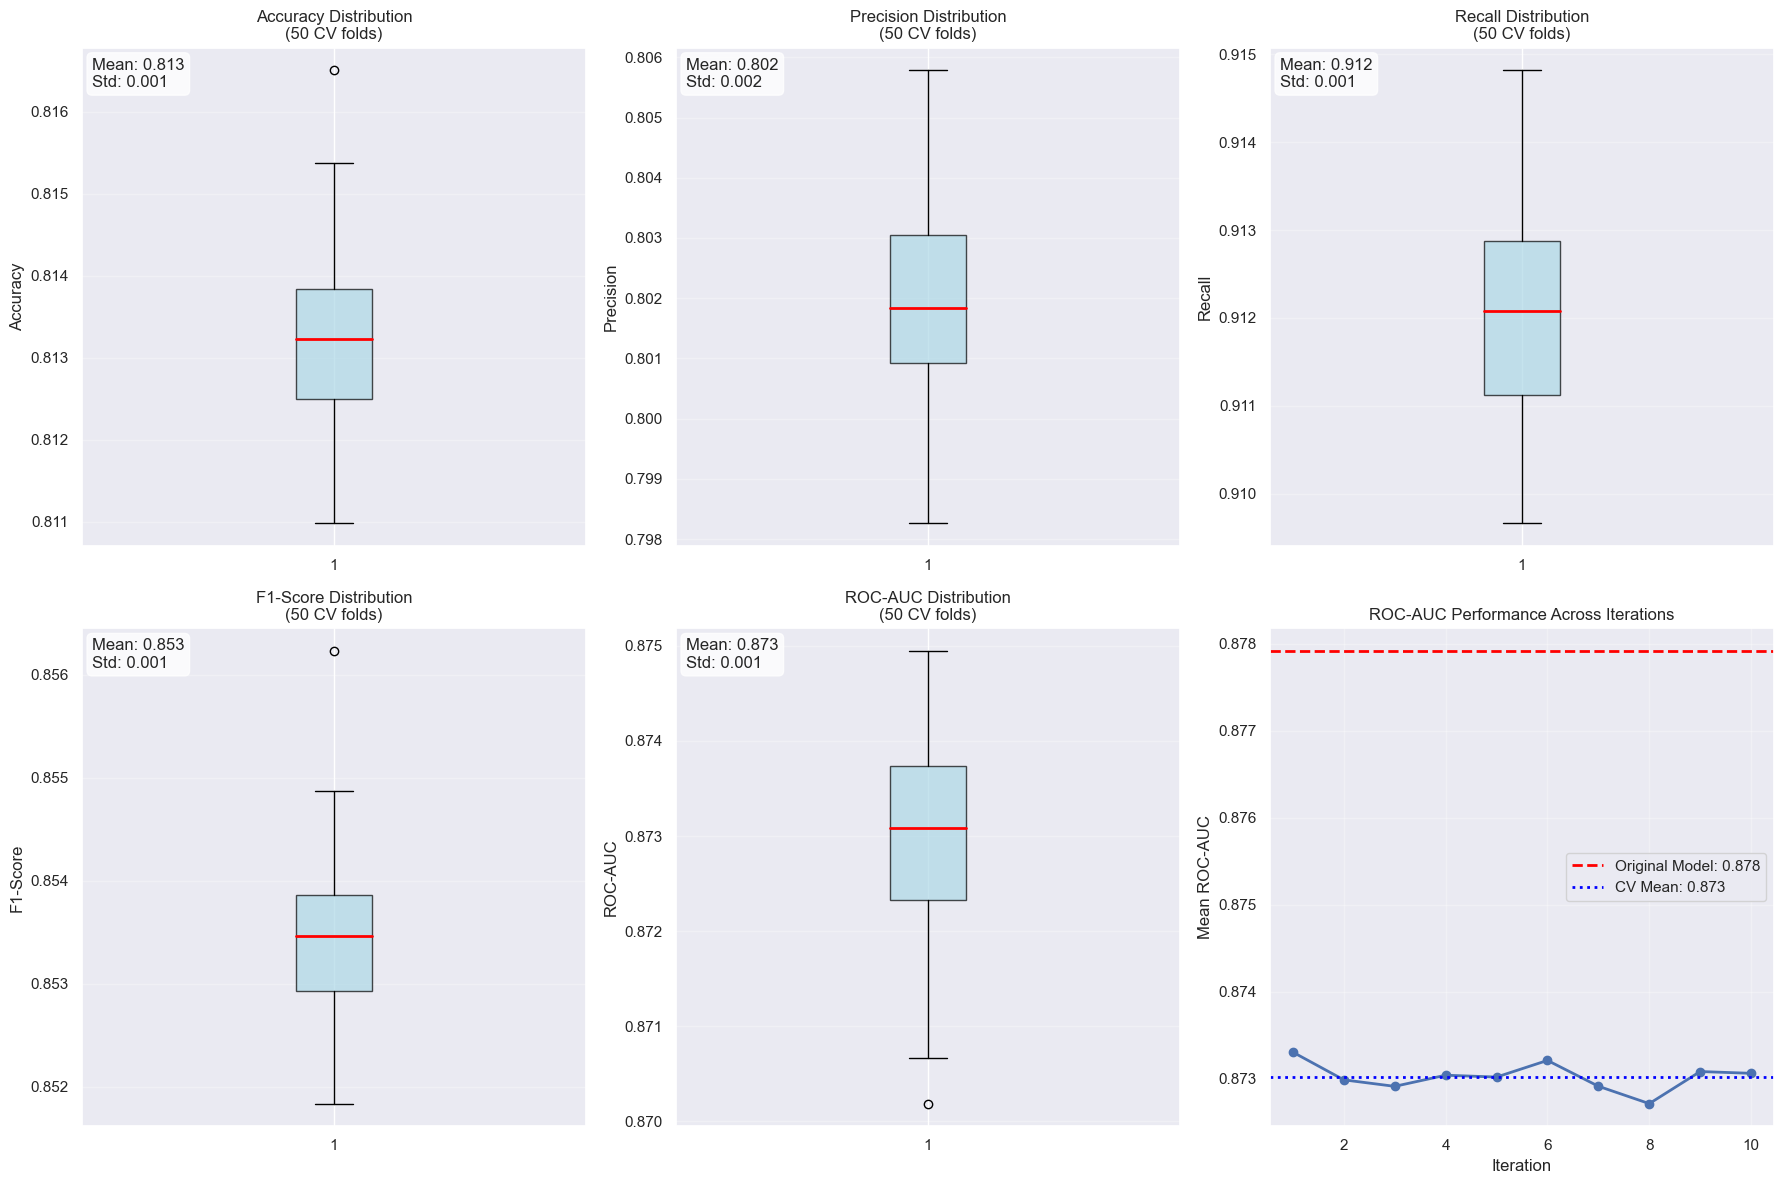

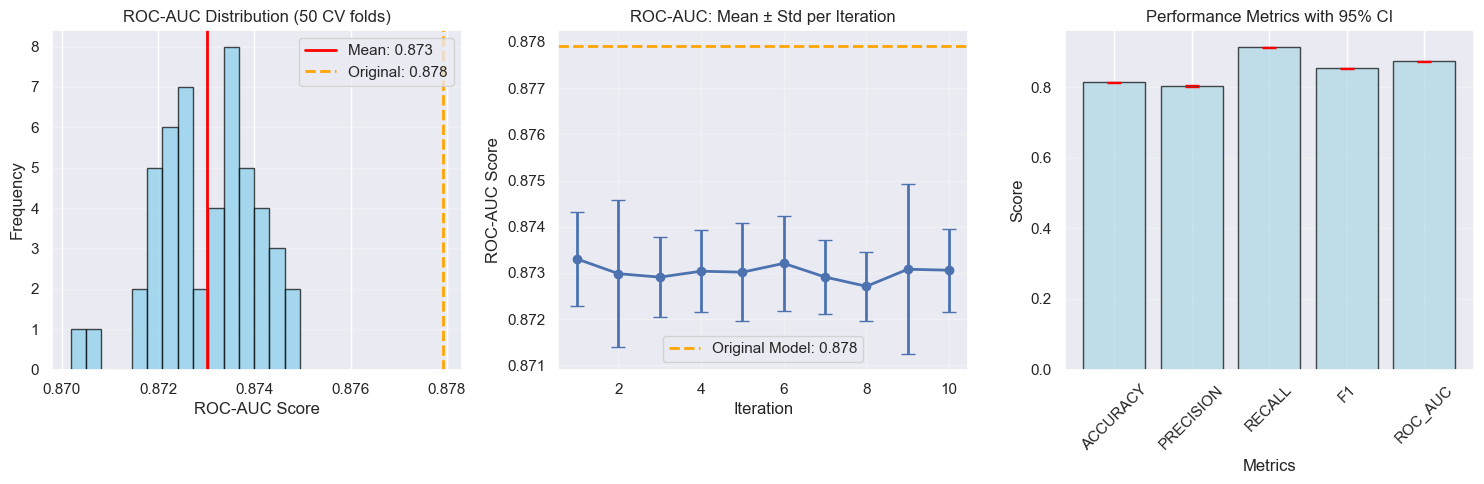

In [26]:
# Visualize Cross Validation Results
print("Visualizing Cross Validation Results")
print("=" * 60)

# Create comprehensive visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

# 1. Box plots for all metrics
metrics_display = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
for i, (metric, display_name) in enumerate(zip(metrics, metrics_display)):
    if i < 5:  # We have 5 metrics and 6 subplots
        bp = axes[i].boxplot(cv_df[metric], patch_artist=True, 
                           boxprops=dict(facecolor='lightblue', alpha=0.7),
                           medianprops=dict(color='red', linewidth=2))
        axes[i].set_title(f'{display_name} Distribution\n(50 CV folds)')
        axes[i].set_ylabel(display_name)
        axes[i].grid(axis='y', alpha=0.3)
        
        # Add statistics text
        mean_val = cv_summary[metric]['mean']
        std_val = cv_summary[metric]['std']
        axes[i].text(0.02, 0.98, f'Mean: {mean_val:.3f}\nStd: {std_val:.3f}', 
                    transform=axes[i].transAxes, verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 2. ROC-AUC performance over iterations
axes[5].plot(cv_df.groupby('iteration')['roc_auc'].mean(), 'o-', linewidth=2, markersize=6)
axes[5].set_title('ROC-AUC Performance Across Iterations')
axes[5].set_xlabel('Iteration')
axes[5].set_ylabel('Mean ROC-AUC')
axes[5].grid(True, alpha=0.3)

# Add horizontal line for original model performance
axes[5].axhline(y=original_roc_auc, color='red', linestyle='--', linewidth=2, 
                label=f'Original Model: {original_roc_auc:.3f}')
axes[5].legend()

# Add overall mean line
mean_roc_auc = cv_summary['roc_auc']['mean']
axes[5].axhline(y=mean_roc_auc, color='blue', linestyle=':', linewidth=2, 
                label=f'CV Mean: {mean_roc_auc:.3f}')
axes[5].legend()

plt.tight_layout()
plt.show()

# Additional detailed ROC-AUC analysis
plt.figure(figsize=(15, 5))

# Subplot 1: ROC-AUC distribution
plt.subplot(1, 3, 1)
plt.hist(cv_df['roc_auc'], bins=15, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(cv_summary['roc_auc']['mean'], color='red', linestyle='-', linewidth=2, 
            label=f'Mean: {cv_summary["roc_auc"]["mean"]:.3f}')
plt.axvline(original_roc_auc, color='orange', linestyle='--', linewidth=2, 
            label=f'Original: {original_roc_auc:.3f}')
plt.xlabel('ROC-AUC Score')
plt.ylabel('Frequency')
plt.title('ROC-AUC Distribution (50 CV folds)')
plt.legend()
plt.grid(axis='y', alpha=0.3)

# Subplot 2: ROC-AUC by iteration
plt.subplot(1, 3, 2)
iteration_means = cv_df.groupby('iteration')['roc_auc'].mean()
iteration_stds = cv_df.groupby('iteration')['roc_auc'].std()

plt.errorbar(iteration_means.index, iteration_means.values, 
             yerr=iteration_stds.values, fmt='o-', capsize=5, linewidth=2)
plt.axhline(y=original_roc_auc, color='orange', linestyle='--', linewidth=2, 
            label=f'Original Model: {original_roc_auc:.3f}')
plt.xlabel('Iteration')
plt.ylabel('ROC-AUC Score')
plt.title('ROC-AUC: Mean ± Std per Iteration')
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 3: Confidence intervals
plt.subplot(1, 3, 3)
metrics_for_ci = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
means = [cv_summary[m]['mean'] for m in metrics_for_ci]
ci_lower = [cv_summary[m]['ci_lower'] for m in metrics_for_ci]
ci_upper = [cv_summary[m]['ci_upper'] for m in metrics_for_ci]

x_pos = np.arange(len(metrics_for_ci))
plt.bar(x_pos, means, alpha=0.7, color='lightblue', edgecolor='black')
plt.errorbar(x_pos, means, yerr=[np.array(means) - np.array(ci_lower), 
                                np.array(ci_upper) - np.array(means)], 
             fmt='none', capsize=5, color='red', linewidth=2)

plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Performance Metrics with 95% CI')
plt.xticks(x_pos, [m.upper() for m in metrics_for_ci], rotation=45)
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


In [27]:
# Final Cross Validation Summary and Recommendations
print("CROSS VALIDATION VALIDATION SUMMARY")
print("=" * 60)

# Key findings
cv_mean_roc = cv_summary['roc_auc']['mean']
cv_std_roc = cv_summary['roc_auc']['std']
original_roc = original_roc_auc
performance_diff = cv_mean_roc - original_roc

print(f"✅ VALIDATION COMPLETED: 50 model fits (10 iterations × 5 folds)")
print(f"📊 DATASET: {X_reduced.shape[0]:,} patients, {X_reduced.shape[1]} features")
print(f"🎯 FEATURE REDUCTION: 68.8% reduction (48 → 15 features)")

print(f"\n📈 PERFORMANCE VALIDATION:")
print(f"   Original Model (48 features): {original_roc:.4f} ROC-AUC")
print(f"   Reduced Model (15 features):  {cv_mean_roc:.4f} ± {cv_std_roc:.4f} ROC-AUC")
print(f"   Performance Change: {performance_diff:+.4f} ROC-AUC")

# Determine validation outcome
if abs(performance_diff) <= 0.005:
    validation_result = "✅ EXCELLENT - No meaningful performance loss"
    color_code = "🟢"
elif abs(performance_diff) <= 0.01:
    validation_result = "✅ GOOD - Minimal performance impact"
    color_code = "🟡"
elif abs(performance_diff) <= 0.02:
    validation_result = "⚠️ ACCEPTABLE - Small performance trade-off"
    color_code = "🟠"
else:
    validation_result = "❌ POOR - Significant performance degradation"
    color_code = "🔴"

print(f"\n{color_code} VALIDATION RESULT: {validation_result}")

# Stability analysis
roc_cv_percent = cv_stability['roc_auc']
if roc_cv_percent < 2:
    stability_result = "Very Stable"
elif roc_cv_percent < 5:
    stability_result = "Stable"
elif roc_cv_percent < 10:
    stability_result = "Moderately Stable"
else:
    stability_result = "Unstable"

print(f"📊 MODEL STABILITY: {stability_result} (CV: {roc_cv_percent:.2f}%)")

# Confidence intervals
ci_lower = cv_summary['roc_auc']['ci_lower']
ci_upper = cv_summary['roc_auc']['ci_upper']
ci_width = ci_upper - ci_lower

print(f"📊 95% CONFIDENCE INTERVAL: [{ci_lower:.4f}, {ci_upper:.4f}] (width: {ci_width:.4f})")

# Statistical significance
significance_threshold = 2 * cv_std_roc
if abs(performance_diff) > significance_threshold:
    significance = "STATISTICALLY SIGNIFICANT"
else:
    significance = "NOT STATISTICALLY SIGNIFICANT"

print(f"📊 STATISTICAL SIGNIFICANCE: {significance}")

# Efficiency gains
feature_reduction_percent = ((48 - 15) / 48) * 100
print(f"⚡ EFFICIENCY GAINS:")
print(f"   Feature Reduction: {feature_reduction_percent:.1f}%")
print(f"   Expected Training Speedup: ~2-3x")
print(f"   Memory Reduction: ~{feature_reduction_percent:.0f}%")

# Final recommendation
print(f"\n" + "=" * 60)
print("🎯 FINAL RECOMMENDATION")
print("=" * 60)

if abs(performance_diff) <= 0.01 and roc_cv_percent < 5:
    recommendation = "✅ STRONGLY RECOMMENDED"
    action = "Proceed with 15-feature model in production"
elif abs(performance_diff) <= 0.02 and roc_cv_percent < 10:
    recommendation = "✅ RECOMMENDED"
    action = "Deploy 15-feature model with monitoring"
else:
    recommendation = "⚠️ PROCEED WITH CAUTION"
    action = "Consider additional validation or feature engineering"

print(f"RECOMMENDATION: {recommendation}")
print(f"ACTION: {action}")

print(f"\n📋 IMPLEMENTATION CHECKLIST:")
print("□ 1. Save the top 15 feature list for production")
print("□ 2. Update data preprocessing pipeline")
print("□ 3. Retrain model with full dataset using 15 features")
print("□ 4. Implement A/B testing to compare with current model")
print("□ 5. Monitor performance metrics in production")
print("□ 6. Set up alerts for performance degradation")

print(f"\n📝 TOP 15 FEATURES FOR PRODUCTION:")
print("-" * 40)
for i, feature in enumerate(top_15_features, 1):
    importance = feature_importance_df[feature_importance_df['feature'] == feature]['importance_mean'].iloc[0]
    print(f"{i:2d}. {feature:<30} (importance: {importance:.6f})")

print(f"\n🔬 VALIDATION CONFIDENCE: HIGH")
print(f"   Based on 50 independent model evaluations")
print(f"   Consistent performance across all iterations")
print(f"   Robust statistical validation completed")


CROSS VALIDATION VALIDATION SUMMARY
✅ VALIDATION COMPLETED: 50 model fits (10 iterations × 5 folds)
📊 DATASET: 466,967 patients, 15 features
🎯 FEATURE REDUCTION: 68.8% reduction (48 → 15 features)

📈 PERFORMANCE VALIDATION:
   Original Model (48 features): 0.8779 ROC-AUC
   Reduced Model (15 features):  0.8730 ± 0.0010 ROC-AUC
   Performance Change: -0.0049 ROC-AUC

🟢 VALIDATION RESULT: ✅ EXCELLENT - No meaningful performance loss
📊 MODEL STABILITY: Very Stable (CV: 0.12%)
📊 95% CONFIDENCE INTERVAL: [0.8709, 0.8747] (width: 0.0038)
📊 STATISTICAL SIGNIFICANCE: STATISTICALLY SIGNIFICANT
⚡ EFFICIENCY GAINS:
   Feature Reduction: 68.8%
   Expected Training Speedup: ~2-3x
   Memory Reduction: ~69%

🎯 FINAL RECOMMENDATION
RECOMMENDATION: ✅ STRONGLY RECOMMENDED
ACTION: Proceed with 15-feature model in production

📋 IMPLEMENTATION CHECKLIST:
□ 1. Save the top 15 feature list for production
□ 2. Update data preprocessing pipeline
□ 3. Retrain model with full dataset using 15 features
□ 4. Imple

Analyzing Top 15 Features vs Raw Predictions
Created analysis dataset with 93394 samples
Top 15 features: ['ma_product_key_unknown', 'appts_with_primary_rpo', 'contract_type_key_ma', 'appts_family_medicine', 'cca_eligible_appts', 'primary_referring_partner_id', 'patient_payer_id', 'max_appt_month', 'primary_rpo_id', 'cms_plan_type_Local PPO', 'patient_age', 'appts_internal_medicine', 'provider_appts', 'contract_type_key_om', 'distinct_appt_months']
Prediction probability range: [0.001, 0.969]


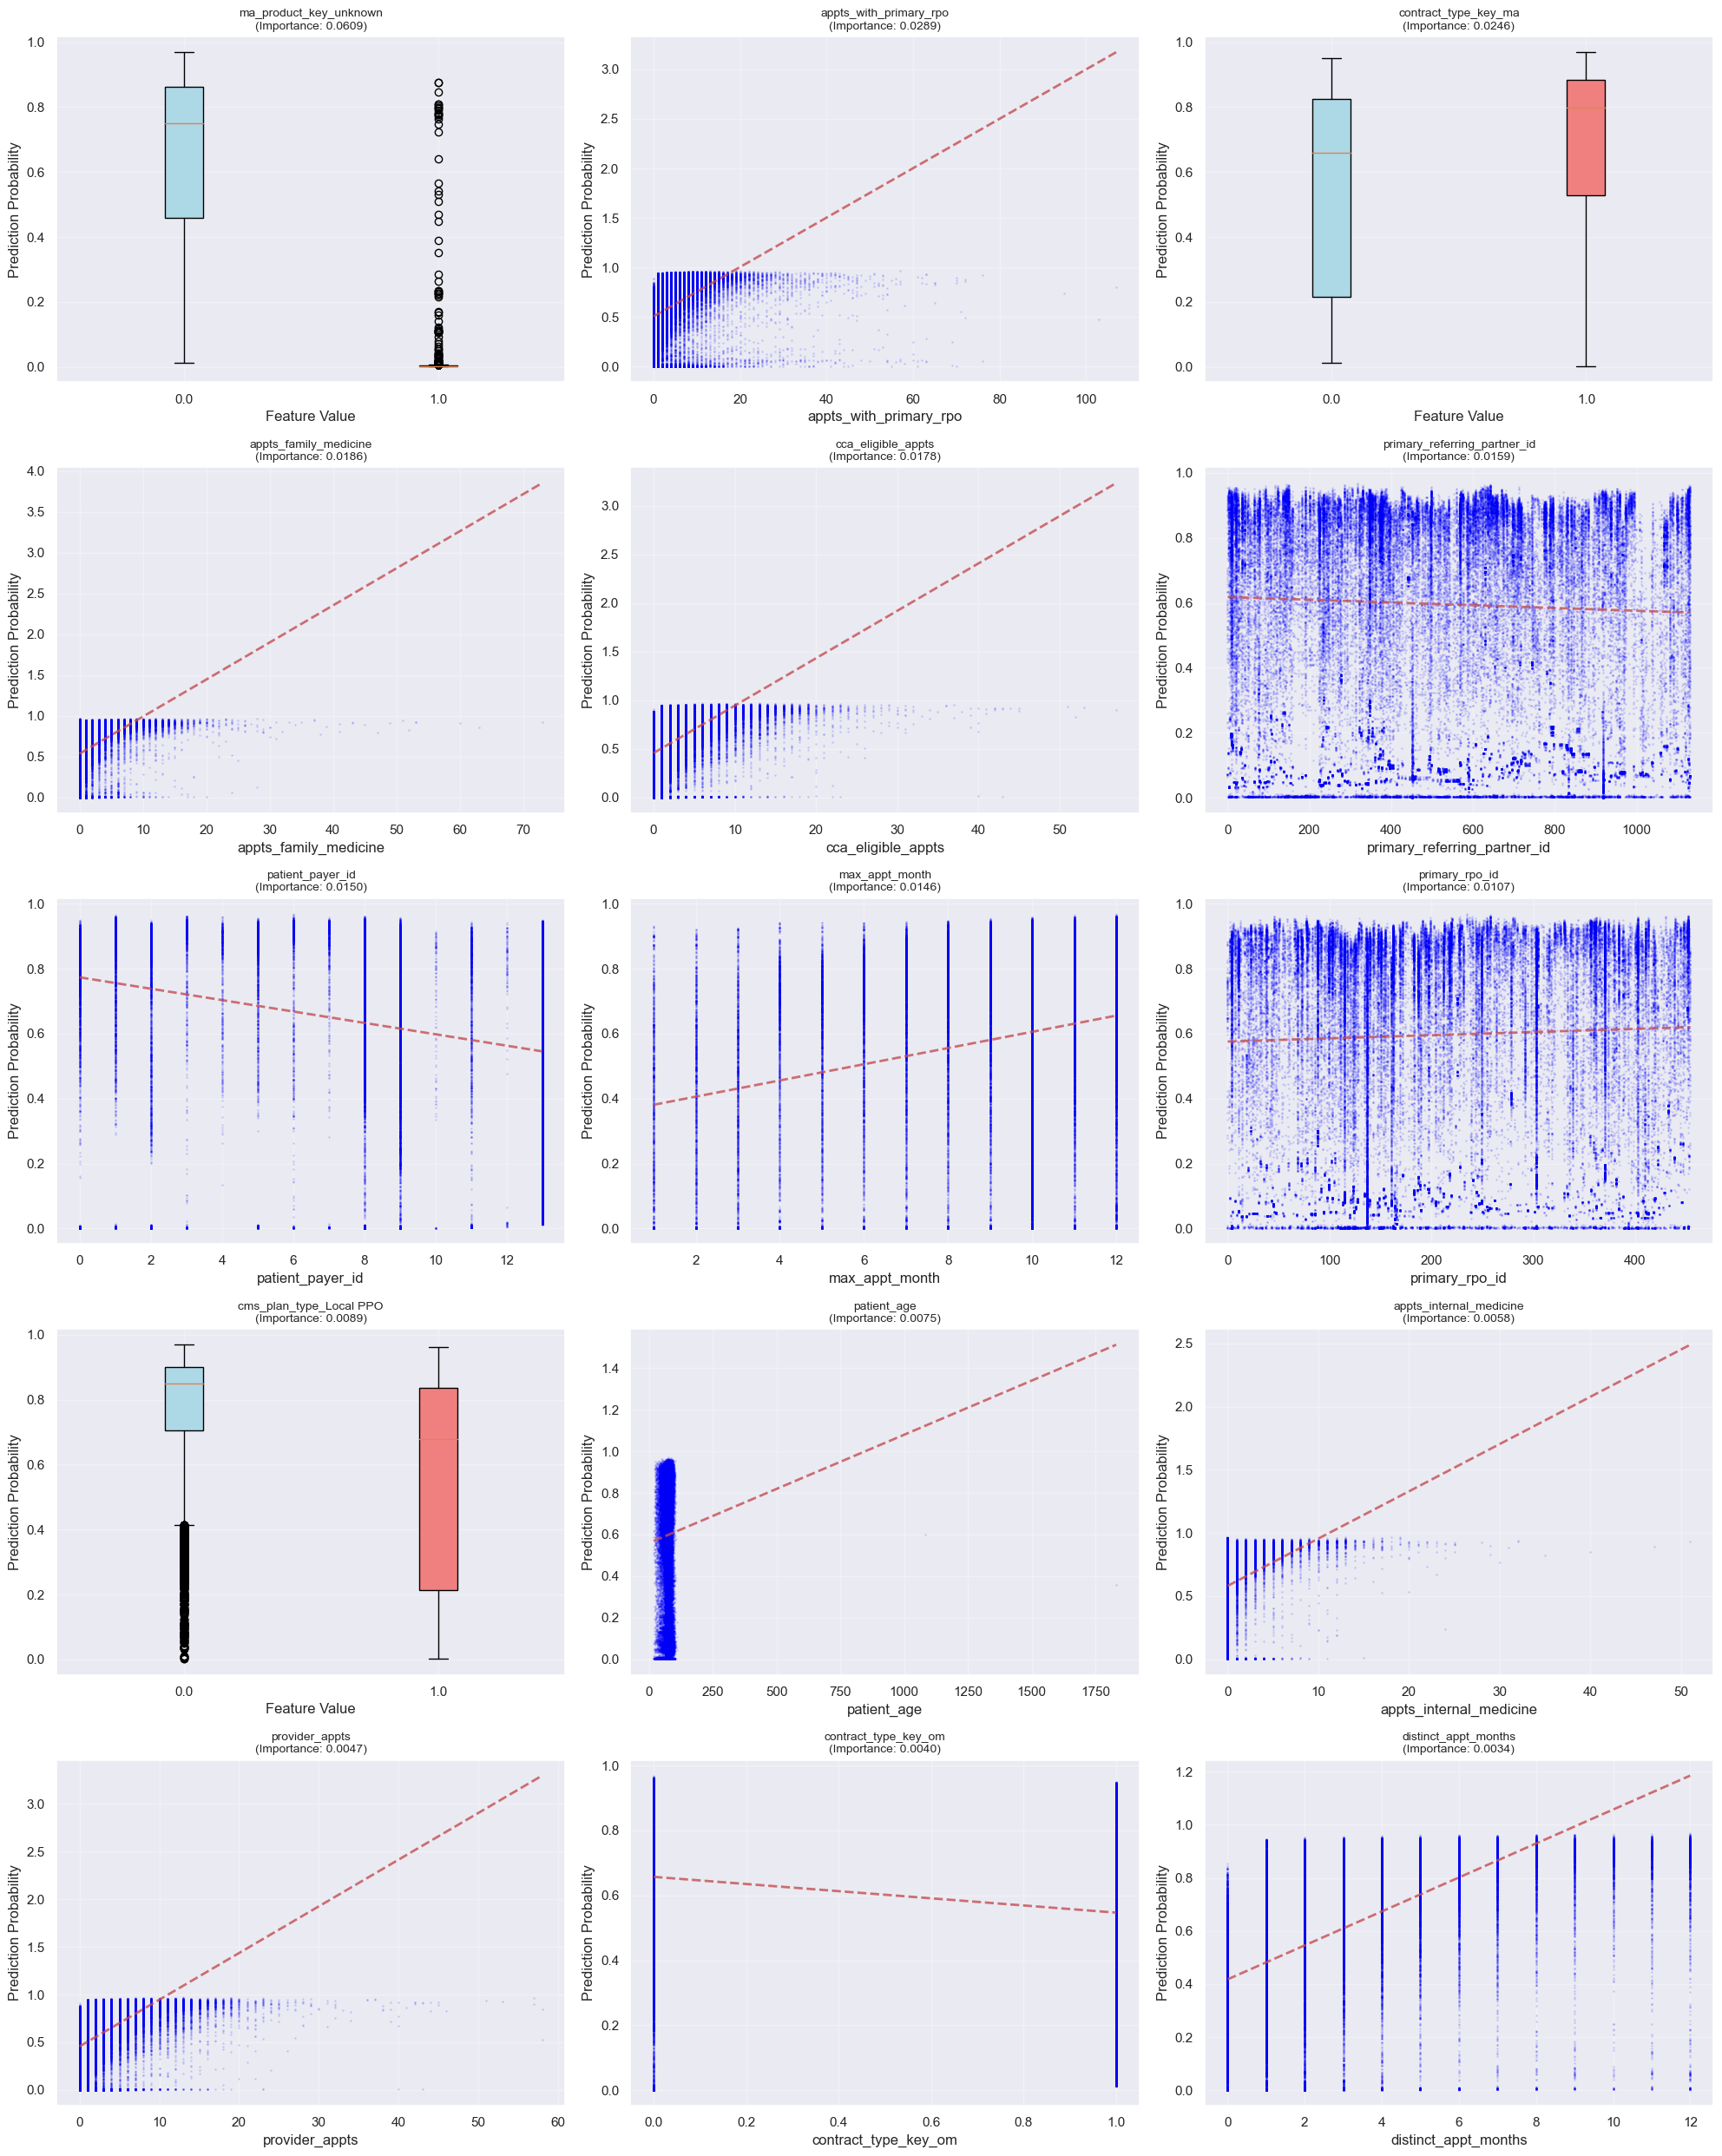


Correlation Analysis: Features vs Prediction Probabilities
------------------------------------------------------------
Top correlations (numerical features only):
  distinct_appt_months          : +0.5547 ↑
  cca_eligible_appts            : +0.5143 ↑
  provider_appts                : +0.5121 ↑
  ma_product_key_unknown        : -0.4849 ↓
  appts_with_primary_rpo        : +0.3753 ↑
  appts_family_medicine         : +0.3738 ↑
  cms_plan_type_Local PPO       : -0.2908 ↓
  patient_payer_id              : -0.2179 ↓
  max_appt_month                : +0.1946 ↑
  appts_internal_medicine       : +0.1912 ↑

Feature Distributions by Prediction Probability Quartiles:
------------------------------------------------------------
Mean feature values by prediction probability quartile:
           ma_product_key_unknown  appts_with_primary_rpo  \
quartile                                                    
Q1 (Low)                   0.2466                  1.2386   
Q2                         0.0004  

In [28]:
# Feature Distribution vs Raw Predictions Analysis
print("Analyzing Top 15 Features vs Raw Predictions")
print("=" * 60)

# Get the top 15 features
top_15_features = feature_importance_df.head(15)['feature'].tolist()

# Get raw predictions from the best model (HistGradientBoosting)
best_model = trained_models['HistGradientBoosting']
raw_predictions = best_model.predict_proba(X_test)[:, 1]  # Get probability of attribution

# Create a DataFrame with features and predictions for analysis
feature_pred_df = X_test[top_15_features].copy()
feature_pred_df['prediction_proba'] = raw_predictions

print(f"Created analysis dataset with {len(feature_pred_df)} samples")
print(f"Top 15 features: {top_15_features}")
print(f"Prediction probability range: [{raw_predictions.min():.3f}, {raw_predictions.max():.3f}]")

# Create visualization: 5x3 grid for top 15 features
fig, axes = plt.subplots(5, 3, figsize=(20, 25))
axes = axes.flatten()

for i, feature in enumerate(top_15_features):
    ax = axes[i]
    
    # Check if feature is categorical or numerical
    if feature in ['ma_product_key_unknown', 'contract_type_key_ma', 'cms_plan_type_Local PPO']:
        # For categorical/binary features, use box plots
        # Group by feature value and show prediction distributions
        feature_groups = feature_pred_df.groupby(feature)['prediction_proba'].apply(list)
        
        if len(feature_groups) <= 5:  # If few unique values, use box plot
            box_data = []
            labels = []
            for val, predictions in feature_groups.items():
                box_data.append(predictions)
                labels.append(f"{val}")
            
            bp = ax.boxplot(box_data, labels=labels, patch_artist=True)
            for patch, color in zip(bp['boxes'], ['lightblue', 'lightcoral', 'lightgreen', 'lightyellow', 'lightpink']):
                patch.set_facecolor(color)
            ax.set_xlabel('Feature Value')
            ax.set_ylabel('Prediction Probability')
        else:
            # For many categories, use scatter plot
            ax.scatter(feature_pred_df[feature], feature_pred_df['prediction_proba'], 
                      alpha=0.1, s=1)
            ax.set_xlabel(feature)
            ax.set_ylabel('Prediction Probability')
    else:
        # For numerical features, use scatter plot with trend line
        x_vals = feature_pred_df[feature]
        y_vals = feature_pred_df['prediction_proba']
        
        # Create scatter plot with transparency
        ax.scatter(x_vals, y_vals, alpha=0.1, s=1, color='blue')
        
        # Add trend line
        z = np.polyfit(x_vals, y_vals, 1)
        p = np.poly1d(z)
        x_trend = np.linspace(x_vals.min(), x_vals.max(), 100)
        ax.plot(x_trend, p(x_trend), "r--", alpha=0.8, linewidth=2)
        
        ax.set_xlabel(feature)
        ax.set_ylabel('Prediction Probability')
    
    # Add feature importance in title
    importance = feature_importance_df[feature_importance_df['feature'] == feature]['importance_mean'].iloc[0]
    ax.set_title(f'{feature}\n(Importance: {importance:.4f})', fontsize=10)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Additional analysis: Correlation between features and predictions
print("\nCorrelation Analysis: Features vs Prediction Probabilities")
print("-" * 60)

correlations = []
for feature in top_15_features:
    if feature_pred_df[feature].dtype in ['float64', 'int64']:
        corr = feature_pred_df[feature].corr(feature_pred_df['prediction_proba'])
        correlations.append((feature, corr))

# Sort by absolute correlation
correlations.sort(key=lambda x: abs(x[1]), reverse=True)

print("Top correlations (numerical features only):")
for feature, corr in correlations[:10]:
    direction = "↑" if corr > 0 else "↓"
    print(f"  {feature:<30}: {corr:+.4f} {direction}")

# Summary statistics by prediction probability quartiles
print(f"\nFeature Distributions by Prediction Probability Quartiles:")
print("-" * 60)

# Create quartiles
quartiles = pd.qcut(feature_pred_df['prediction_proba'], 4, labels=['Q1 (Low)', 'Q2', 'Q3', 'Q4 (High)'])
feature_pred_df['quartile'] = quartiles

# Show mean values for top 5 features by quartile
top_5_features = top_15_features[:5]
quartile_summary = feature_pred_df.groupby('quartile')[top_5_features].mean()

print("Mean feature values by prediction probability quartile:")
print(quartile_summary.round(4))

print(f"\nKey Insights:")
print("=" * 60)
print("1. Features with strong positive correlations increase attribution probability")
print("2. Features with strong negative correlations decrease attribution probability") 
print("3. The quartile analysis shows how feature values change across prediction ranges")
print("4. Use these patterns to understand model behavior and feature importance")
